# Project Overview

## Scope
- Analyze multiple local CSV datasets to identify possible relationships and correlations.
- Automatically detect:
  - Schema similarities (column names/types)
  - Shared data or overlapping values
  - Entity links across datasets
  - Potential geographic or temporal relationships
- Designed for datasets like public records (e.g., crime reports, arrest logs).

## Functionality
- Load all CSV files from a specified local directory.
- Perform random sampling and lightweight profiling on each dataset.
- Use a locally hosted LLM (via Ollama API) to:
  - Interpret dataset structure and content
  - Suggest how datasets might relate
  - Propose possible joins, correlations, or common entities
- Print human-readable output with insights.
- Modular Jupyter Notebook format, broken into logical steps.

## Architecture & Design
- **Environment**: Jupyter Notebook with Python 3.x.
- **File Input**: Local CSV files in a defined directory.
- **Sampling**: Random subset per dataset to limit memory and improve performance.
- **Profiling**: Per-column metadata (types, unique counts, missing %, examples).
- **LLM Integration**:
  - Prompt built from samples and profiles
  - LLMs called via HTTP API (`http://localhost:11434/`)
  - Model is configurable (e.g., LLaMA3, Mistral)
- **Extensibility**: Designed to support future features like:
  - Visualization of relationships
  - Dataset joining
  - Output logging
  - Database integration


## Useful commands

  - Print field names
```python
print(crime_df.columns.tolist())
```

## Cell 1: Project Setup & Configuration

### Purpose
Initialize configuration variables and environment settings for the dataset analysis notebook. This includes setting:
- The path to the folder containing local CSV files
- Sampling and profiling parameters
- Ollama API connection details and LLM model selection

This cell prepares the foundation for all downstream steps.

---

### Inputs
None from the user at runtime, but the developer must:
- Set the `DATA_FOLDER` path (string): absolute path to the folder containing `.csv` files
- Set the `SAMPLE_SIZE` (int): how many rows to randomly sample per dataset
- Set the `SEED` (int): for reproducibility of sampling
- Set the `OLLAMA_API_URL` (string): URL where the Ollama service is listening (default `http://localhost:11434/`)
- Set the `LLM_MODEL` (string): model to be used via Ollama (e.g., `llama3.1:latest`)

---

### Outputs
- Global variables stored in the Jupyter notebook environment:
  - `DATA_FOLDER`
  - `SAMPLE_SIZE`
  - `SEED`
  - `OLLAMA_API_URL`
  - `LLM_MODEL`

- Print output confirming:
  - Directory being scanned
  - Number of rows to sample
  - Model and endpoint in use

---

### Behavior & Comments
- Include an introductory Markdown comment block in the cell explaining what this setup does.
- All variables should be defined clearly and separately, not embedded in function calls.
- Add inline comments for each configuration line to explain what it controls.
- Include `print()` statements to inform the user what values are being set and used.
- No external libraries are required in this cell.

---

### Extensibility Notes
- This cell may later include additional configuration for output logging, file filters (e.g., by filename keyword), or dataset limits.
- Ollama model names and endpoint URL should be easy to change from this one cell.



In [1]:
# ============================================
# Cell 1: Project Setup & Configuration
# ============================================
# This cell initializes the configuration for the dataset analysis project.
#
# INPUTS:
#   - Folder path to local CSV files
#   - Sample size for random row selection
#   - Random seed for reproducibility
#   - Ollama API endpoint and model name
#
# OUTPUTS:
#   - Variables available throughout the notebook:
#       DATA_FOLDER, SAMPLE_SIZE, SEED, OLLAMA_API_URL, LLM_MODEL
#   - Console output confirming the configuration

# Path to the folder containing your CSV datasets
DATA_FOLDER = "/m2-data/dataSets/csv"  

# Number of rows to sample from each dataset
SAMPLE_SIZE = 100

# Random seed for reproducibility
SEED = 42

# Ollama API endpoint URL
OLLAMA_API_URL = "http://localhost:11434"

# Name of the LLM model to use via Ollama
LLM_MODEL = "llama3.1:latest"

# Print configuration status
print("Configuration initialized:")
print(f"  Data folder: {DATA_FOLDER}")
print(f"  Sample size: {SAMPLE_SIZE} rows per dataset")
print(f"  Random seed: {SEED}")
print(f"  LLM model: {LLM_MODEL}")
print(f"  Ollama API URL: {OLLAMA_API_URL}")


Configuration initialized:
  Data folder: /m2-data/dataSets/csv
  Sample size: 100 rows per dataset
  Random seed: 42
  LLM model: llama3.1:latest
  Ollama API URL: http://localhost:11434


## Cell 2: Load CSV Files

### Purpose
Scan the specified local directory for CSV files and load each file into a pandas DataFrame. Store all loaded datasets in a dictionary for downstream processing.

---

### Inputs
- `DATA_FOLDER` (string): Path to the folder containing `.csv` files
- Assumes `pandas` is available

---

### Outputs
- `datasets` (dict): Mapping from filename to `pandas.DataFrame`
- Console output:
  - Number of files found and loaded
  - Number of rows and columns in each dataset
  - Warnings if any files fail to load

---

### Behavior & Comments
- Use `os.listdir()` to identify `.csv` files
- Use `pandas.read_csv()` to load each dataset
- Handle file loading errors with `try/except` and print useful messages
- All filenames used as keys in the dictionary should remain unmodified (no path stripping)
- Avoid loading non-CSV files even if present in the folder

---

### Extensibility Notes
- This cell could later support filtering by filename (e.g., wildcard or prefix)
- May be extended to support file size limits or preview mode
- Could be refactored into a reusable utility function if needed


In [2]:
# ============================================
# Cell 2: Load CSV Files
# ============================================
# This cell scans the specified folder for CSV files and loads each file into a pandas DataFrame.
#
# INPUT:
#   - DATA_FOLDER: Folder path defined in Cell 1.
#
# OUTPUT:
#   - datasets: Dictionary of {filename: DataFrame} for successfully loaded CSVs.
#   - Status messages printed to the console.

import os
import pandas as pd

# Initialize dictionary to hold datasets
datasets = {}

# List all files in the folder that end with ".csv" (case-insensitive)
print(f"Scanning folder for CSV files: {DATA_FOLDER}")
all_files = os.listdir(DATA_FOLDER)
csv_files = [f for f in all_files if f.lower().endswith(".csv")]

print(f"Found {len(csv_files)} CSV file(s):")
for f in csv_files:
    print(f"  - {f}")

# Load each CSV file into a pandas DataFrame
for fname in csv_files:
    file_path = os.path.join(DATA_FOLDER, fname)
    print(f"Loading file: {fname}")
    try:
        df = pd.read_csv(file_path)
        datasets[fname] = df
        print(f"  Successfully loaded: {fname} ({df.shape[0]} rows, {df.shape[1]} columns)")
    except Exception as e:
        print(f"  Failed to load '{fname}'. Error: {e}")

# Summary
print(f"Finished loading. Successfully loaded {len(datasets)} of {len(csv_files)} file(s).")


Scanning folder for CSV files: /m2-data/dataSets/csv
Found 3 CSV file(s):
  - LA-Crime_Data_from_2020_to_Present.csv
  - LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv
  - Arrest_Data_from_2020_to_Present.csv
Loading file: LA-Crime_Data_from_2020_to_Present.csv
  Successfully loaded: LA-Crime_Data_from_2020_to_Present.csv (1005109 rows, 28 columns)
Loading file: LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv


/tmp/ipykernel_70365/2521258603.py:33: DtypeWarning: Columns (7,8,9,70,102,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


  Successfully loaded: LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv (3156443 rows, 135 columns)
Loading file: Arrest_Data_from_2020_to_Present.csv
  Successfully loaded: Arrest_Data_from_2020_to_Present.csv (342735 rows, 25 columns)
Finished loading. Successfully loaded 3 of 3 file(s).


## Sample and Profile Each Dataset

### Purpose
For each dataset loaded in the previous step:
- Randomly sample a subset of rows
- Generate lightweight profiling metadata for each column

This helps the LLM later reason about what each dataset contains and how they might relate.

---

### Inputs
- `datasets` (dict): Dictionary of DataFrames from Cell 2
- `SAMPLE_SIZE` (int): Number of rows to sample
- `SEED` (int): Random seed for reproducibility

---

### Outputs
- `samples_and_profiles` (dict): Dictionary containing, for each file:
  - `sample`: Sampled data (list of row dictionaries)
  - `profile`: Metadata per column including:
    - Data type
    - Percentage of missing values
    - Number of unique values
    - Sample values
    - Min/max values for numeric or datetime types
- Console output:
  - Confirmation of profiling per file
  - Warnings if sampling or profiling fails

---

### Behavior & Comments
- Use `DataFrame.sample()` to extract a random sample of rows
- Loop through each column and compute:
  - `dtype`, `isna().mean()`, `nunique()`
  - Top 5 distinct non-null values (for context)
  - `min()` and `max()` for numeric or datetime columns
- Wrap processing in try/except and print errors if encountered
- Keep profiling lightweight and fast
- Use status messages to indicate progress through datasets

---

### Extensibility Notes
- Could be extended to include full statistics (e.g., std dev, histogram bins)
- Sampling approach can be changed to stratified or head/tail sampling


In [3]:
# ============================================
# Cell 3: Sample and Profile Each Dataset
# ============================================
# This cell performs two tasks for each loaded dataset:
#   1. Randomly sample a number of rows for lightweight inspection
#   2. Generate profiling metadata for each column in the dataset
#
# INPUTS:
#   - datasets: Dictionary of {filename: DataFrame} from Cell 2
#   - SAMPLE_SIZE: Number of rows to sample from each dataset
#   - SEED: Random seed for reproducibility
#
# OUTPUT:
#   - samples_and_profiles: Dictionary where each key is a filename and the value is a dictionary with:
#       - 'sample': List of sampled row dicts (used for LLM prompt)
#       - 'profile': Metadata for each column (type, missing %, unique count, example values, min/max)

samples_and_profiles = {}

print("Beginning sampling and profiling for all datasets...")

for fname, df in datasets.items():
    print(f"Processing: {fname}")
    profile = {}

    try:
        # Ensure we don't sample more rows than exist in the dataset
        sample_count = min(SAMPLE_SIZE, len(df))
        
        # Randomly sample rows from the dataset
        sampled = df.sample(n=sample_count, random_state=SEED)

        # Iterate through each column to generate a profile
        for col in df.columns:
            series = df[col]
            col_profile = {
                "type": str(series.dtype),
                "missing_pct": round(series.isna().mean(), 4),
                "unique_vals": int(series.nunique(dropna=True)),
                "sample_values": series.dropna().unique()[:5].tolist()
            }

            # If column is numeric or datetime-like, capture min and max
            if pd.api.types.is_numeric_dtype(series) or pd.api.types.is_datetime64_any_dtype(series):
                col_profile["min"] = series.min()
                col_profile["max"] = series.max()

            profile[col] = col_profile

        # Store the sample and profile together
        samples_and_profiles[fname] = {
            "sample": sampled.head(5).to_dict(orient="records"),
            "profile": profile
        }

        print(f"  Sampled {sample_count} rows, profiled {len(profile)} columns")

    except Exception as e:
        print(f"  Warning: Failed to process '{fname}'. Error: {e}")

print("Completed profiling all datasets.")


Beginning sampling and profiling for all datasets...
Processing: LA-Crime_Data_from_2020_to_Present.csv
  Sampled 100 rows, profiled 28 columns
Processing: LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv
  Sampled 100 rows, profiled 135 columns
Processing: Arrest_Data_from_2020_to_Present.csv
  Sampled 100 rows, profiled 25 columns
Completed profiling all datasets.


## Generate Prompt and Query LLM

### Purpose
Construct a prompt from the profiling and sample data generated in Cell 3, then send this prompt to a locally running LLM via the Ollama API. The LLM should return insights about how the datasets may be related.

---

### Inputs
- `samples_and_profiles` (dict): Output from Cell 3, containing sampled rows and profiling metadata
- `OLLAMA_API_URL` (string): URL of the Ollama API (e.g., `http://localhost:11434`)
- `LLM_MODEL` (string): Name of the model to use with Ollama (e.g., `llama3.1:latest`)

---

### Outputs
- `llm_response` (string): Text response from the LLM
- Console output:
  - Notice when the prompt is constructed
  - Notice when the API call is made
  - Success or failure message after the API call
  - Final printed LLM response (summarized if long)

---

### Behavior & Comments
- Loop over each dataset in `samples_and_profiles`
  - Include dataset name, column metadata, and 3–5 sampled rows per file
- Format the full prompt as plain text (not JSON)
  - Use clean, readable formatting suitable for LLM interpretation
- Send the prompt to Ollama using HTTP POST to `/api/generate`
  - Use `requests` library to make the API call
  - POST body should include: `model`, `prompt`, and `stream: false`
- Check for and handle HTTP or JSON errors gracefully
- Print a status message after querying the LLM

---

### Extensibility Notes
- May support streaming output or function calling in future Ollama versions
- Could support prompt templates to standardize instructions
- Could be modified to log input/output pairs for auditing


In [4]:
# ============================================
# Cell 4: Generate Prompt and Query LLM
# ============================================
# This cell takes the output from Cell 3 (samples and profiling) and:
#   1. Constructs a plain text prompt for an LLM to analyze dataset relationships
#   2. Sends the prompt to a local Ollama model via its API
#   3. Prints the LLM's response, which includes insights about how the datasets may be related
#
# INPUTS:
#   - samples_and_profiles: Dictionary of {filename: {sample, profile}} from Cell 3
#   - OLLAMA_API_URL: Endpoint where Ollama is listening
#   - LLM_MODEL: The name of the LLM model to use via Ollama
#
# OUTPUT:
#   - llm_response: Text string containing the LLM's output
#   - Printed status and response to console

import requests
import json

def build_prompt(samples_and_profiles):
    """
    Builds a prompt for the LLM based on the dataset samples and profiles.
    The prompt is structured in plain text for natural interpretation by the LLM.
    """
    prompt = (
        "You are a data analyst AI. Your task is to analyze the following datasets "
        "to determine how they might be related. Identify potential joins, common entities, "
        "matching column names or types, overlapping values, and possible correlations.\n\n"
    )

    for fname, content in samples_and_profiles.items():
        prompt += f"Dataset: {fname}\n"
        prompt += "Columns and metadata:\n"
        for col, meta in content["profile"].items():
            prompt += (
                f"  - {col}: type={meta['type']}, unique={meta['unique_vals']}, "
                f"missing_pct={meta['missing_pct']}\n"
            )
        prompt += "Sample rows:\n"
        for row in content["sample"]:
            prompt += f"  {row}\n"
        prompt += "\n"

    prompt += (
        "Provide a summary of relationships between these datasets. "
        "Explain any shared fields, related concepts, and suggestions for analysis.\n"
    )
    return prompt

# Build the prompt from the profiling and sample data
print("Building prompt for LLM...")
prompt_text = build_prompt(samples_and_profiles)

# Prepare payload for Ollama API
payload = {
    "model": LLM_MODEL,
    "prompt": prompt_text,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_response = response.json().get("response", "")

    print("LLM response received:")
    print("-" * 40)
    print(llm_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing response from LLM: {e}")
    llm_response = ""


Building prompt for LLM...
Sending prompt to LLM...
LLM response received:
----------------------------------------
The two datasets provided appear to be related to law enforcement activity in the Los Angeles area. The first dataset appears to contain data on arrests or field contacts (RFC), while the second dataset contains more detailed information about booking events associated with these arrests.

**Shared Fields:**

1. `Report ID`: This field is present in both datasets and can be used to link records between them.
2. `Arrest Date`/`Booking Date`: These fields are related, as they represent the date of arrest or booking event.
3. `Area Name` (`Area ID`): Both datasets contain information about the police area where the incident occurred.
4. `Reporting District`: This field is present in both datasets and may indicate the jurisdiction responsible for reporting the incident.

**Related Concepts:**

1. **Arrest vs. Booking**: The first dataset contains records of arrests or field c

## Cell 5: Compare Shared Fields Across Datasets

### Purpose
Identify and evaluate common column names across datasets, and assess how well their values align. This determines whether those fields can be used to relate or join datasets reliably.

---

### Inputs
- `datasets` (dict): Dictionary of DataFrames from Cell 2

---

### Outputs
- `field_comparisons` (dict): Nested dictionary where keys are dataset pairs and values are:
  - Shared column names
  - Overlap statistics for each shared field:
    - Total unique values per dataset
    - Number of overlapping values
    - Percent overlap (intersection / union)
    - Sample of overlapping and unique values
- Console output:
  - Dataset pairs being compared
  - Shared fields and summary of overlaps
  - Warnings or notes if no shared fields are found

---

### Behavior & Comments
- Compare all unique dataset pairs (e.g., A vs. B, B vs. C)
- For each pair, identify columns with exact name matches
- For each shared column:
  - Extract unique non-null values from both datasets
  - Compute intersection, union, and percent overlap
  - Select example overlapping and non-overlapping values
- Use print statements to log progress and key findings

---

### Extensibility Notes
- Can be extended to fuzzy-match column names (e.g., `AreaID` vs `area_id`)
- Could support data type matching checks (e.g., int vs. string)
- May be refactored into a utility function for reusability


In [5]:
# ============================================
# Cell 5: Compare Shared Fields Across Datasets
# ============================================
# This cell analyzes every unique pair of datasets to:
#   - Identify shared column names
#   - Compute the degree of overlap between values in those columns
#
# INPUT:
#   - datasets: Dictionary of {filename: DataFrame} from Cell 2
#
# OUTPUT:
#   - field_comparisons: Dictionary structured as:
#       {
#         (dataset1, dataset2): {
#             column_name: {
#                 "unique_in_dataset1": int,
#                 "unique_in_dataset2": int,
#                 "shared_values": int,
#                 "percent_overlap": float,
#                 "example_shared": list,
#                 "example_only_in_1": list,
#                 "example_only_in_2": list
#             },
#             ...
#         },
#         ...
#       }
#   - Console output summarizing shared fields and value overlap for each dataset pair

from itertools import combinations

field_comparisons = {}

print("Comparing shared fields across dataset pairs...")

# Generate all unique dataset pairs
dataset_names = list(datasets.keys())
for ds1, ds2 in combinations(dataset_names, 2):
    df1, df2 = datasets[ds1], datasets[ds2]
    shared_columns = set(df1.columns).intersection(df2.columns)

    print(f"\nAnalyzing: '{ds1}' vs. '{ds2}'")
    if not shared_columns:
        print("  No shared columns found.")
        continue

    pair_key = (ds1, ds2)
    field_comparisons[pair_key] = {}

    for col in shared_columns:
        print(f"  Comparing shared field: {col}")
        try:
            values1 = set(df1[col].dropna().unique())
            values2 = set(df2[col].dropna().unique())

            shared = values1.intersection(values2)
            union = values1.union(values2)

            result = {
                "unique_in_dataset1": len(values1),
                "unique_in_dataset2": len(values2),
                "shared_values": len(shared),
                "percent_overlap": round(len(shared) / len(union), 4) if union else 0.0,
                "example_shared": list(shared)[:5],
                "example_only_in_1": list(values1 - values2)[:5],
                "example_only_in_2": list(values2 - values1)[:5]
            }

            field_comparisons[pair_key][col] = result

            # Print summary for this column
            print(f"    Shared values: {result['shared_values']}")
            print(f"    Percent overlap: {result['percent_overlap'] * 100:.2f}%")

        except Exception as e:
            print(f"    Warning: Failed to compare column '{col}'. Error: {e}")

print("\nCompleted field comparison across all dataset pairs.")


Comparing shared fields across dataset pairs...

Analyzing: 'LA-Crime_Data_from_2020_to_Present.csv' vs. 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv'
  No shared columns found.

Analyzing: 'LA-Crime_Data_from_2020_to_Present.csv' vs. 'Arrest_Data_from_2020_to_Present.csv'
  Comparing shared field: Cross Street
    Shared values: 6181
    Percent overlap: 44.22%
  Comparing shared field: LAT
    Shared values: 4853
    Percent overlap: 88.80%
  Comparing shared field: LON
    Shared values: 4630
    Percent overlap: 92.75%

Analyzing: 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv' vs. 'Arrest_Data_from_2020_to_Present.csv'
  Comparing shared field: Area ID
    Shared values: 21
    Percent overlap: 95.45%
  Comparing shared field: Area Name
    Shared values: 16
    Percent overlap: 59.26%
  Comparing shared field: Reporting District
    Shared values: 1135
    Percent overlap: 88.46%

Completed field comparison across all dataset pairs.


## Cell 6: Fuzzy Match Column Names Across Datasets

### Purpose
Identify semantically similar column names across datasets that were not matched exactly. This expands the opportunity to detect relationships between datasets that use inconsistent naming conventions.

---

### Inputs
- `datasets` (dict): Dictionary of DataFrames from Cell 2

---

### Outputs
- `fuzzy_matches` (dict): Dictionary of {dataset pair: list of (column_from_A, column_from_B, similarity_score)}
- Console output:
  - Dataset pairs being compared
  - Likely column name matches based on a similarity threshold
  - Warnings or skips if there are too few columns

---

### Behavior & Comments
- Compare each dataset pair (e.g., A vs B) across all column names (not just exact matches)
- Use fuzzy string matching to compute similarity between column names
- Only retain matches above a threshold (e.g., 85%)
- Avoid redundant pairs (A vs B is same as B vs A)

Recommended matching method:
- Normalize column names (e.g., lowercase, strip spaces and symbols)
- Use `RapidFuzz` or `difflib` to compute similarity scores

---

### Extensibility Notes
- Could be enhanced with token-based or embedding-based matching (e.g., sentence transformers)
- May integrate results with value-level overlap to confirm semantic matches


In [6]:
# ============================================
# Cell 6: Fuzzy Match Column Names Across Datasets
# ============================================
# This cell identifies column names that are semantically similar but not exact matches,
# using fuzzy string matching to compare all column names between dataset pairs.
#
# INPUT:
#   - datasets: Dictionary of {filename: DataFrame} from Cell 2
#
# OUTPUT:
#   - fuzzy_matches: Dictionary of {(dataset1, dataset2): [ (col_A, col_B, score), ... ]}
#   - Printed matches with similarity scores above a defined threshold

from itertools import combinations
from rapidfuzz import fuzz

# Threshold for match confidence (adjustable)
SIMILARITY_THRESHOLD = 85

# Dictionary to hold match results
fuzzy_matches = {}

print("Running fuzzy column name matching across dataset pairs...")

dataset_names = list(datasets.keys())

for ds1, ds2 in combinations(dataset_names, 2):
    df1, df2 = datasets[ds1], datasets[ds2]
    columns1 = df1.columns
    columns2 = df2.columns

    matches = []

    print(f"\nComparing column names between '{ds1}' and '{ds2}'")

    for col1 in columns1:
        for col2 in columns2:
            # Normalize column names for better matching
            norm_col1 = col1.lower().replace(" ", "").replace("_", "")
            norm_col2 = col2.lower().replace(" ", "").replace("_", "")

            # Compute similarity score
            score = fuzz.ratio(norm_col1, norm_col2)

            if score >= SIMILARITY_THRESHOLD:
                matches.append((col1, col2, score))

    if matches:
        fuzzy_matches[(ds1, ds2)] = matches
        print("  Likely matches found:")
        for col1, col2, score in matches:
            print(f"    {col1}  <-->  {col2}  (Similarity: {score}%)")
    else:
        print("  No likely matches above threshold.")

print("\nCompleted fuzzy matching of column names.")


Running fuzzy column name matching across dataset pairs...

Comparing column names between 'LA-Crime_Data_from_2020_to_Present.csv' and 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv'
  Likely matches found:
    AREA NAME  <-->  Area Name  (Similarity: 100.0%)

Comparing column names between 'LA-Crime_Data_from_2020_to_Present.csv' and 'Arrest_Data_from_2020_to_Present.csv'
  Likely matches found:
    AREA NAME  <-->  Area Name  (Similarity: 100.0%)
    LOCATION  <-->  Location  (Similarity: 100.0%)
    Cross Street  <-->  Cross Street  (Similarity: 100.0%)
    LAT  <-->  LAT  (Similarity: 100.0%)
    LON  <-->  LON  (Similarity: 100.0%)

Comparing column names between 'LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv' and 'Arrest_Data_from_2020_to_Present.csv'
  Likely matches found:
    Reporting District  <-->  Reporting District  (Similarity: 100.0%)
    Area ID  <-->  Area ID  (Similarity: 100.0%)
    Area Name  <-->  Area Name  (Similarity: 100.0%)

Completed

## Cell 7: Feed Field Comparison Results to the LLM

### Purpose
Use the structured results from earlier shared field comparisons to prompt the LLM with:
- Verified shared columns between datasets
- Overlap metrics (% value overlap, example values)
- Names of datasets involved

Ask the LLM to:
- Suggest join strategies (inner, left, key field priorities)
- Identify high-value analytical opportunities across datasets
- Propose data quality or cleaning improvements

---

### Inputs
- `field_comparisons` (dict): Output from Cell 5, containing overlap analysis
- `OLLAMA_API_URL` (string): URL to Ollama service
- `LLM_MODEL` (string): Selected LLM model name

---

### Outputs
- `llm_field_analysis_response` (string): Response from the LLM with insights
- Console output:
  - Status messages for prompt creation and submission
  - Summary or full LLM response

---

### Behavior & Comments
- Format the prompt with plain English descriptions of shared fields and overlap percentages
- Present the data in a concise but readable structure
- Ask the LLM to recommend:
  - Join strategies
  - Interesting analytical paths
  - Possible data cleanup or normalization steps
- Handle API errors gracefully

---

### Extensibility Notes
- Can be extended to include value-level statistics, fuzzy match confidence, or schema metadata
- Could wrap prompt generation and call into a utility function for reuse


In [7]:
# ============================================
# Cell 7: Feed Field Comparison Results to the LLM
# ============================================
# This cell summarizes the validated field relationships between datasets and
# sends them to the LLM for guidance on join strategies and analysis opportunities.
#
# INPUT:
#   - field_comparisons: Dictionary from Cell 5 with shared field overlap data
#   - OLLAMA_API_URL: The Ollama API endpoint
#   - LLM_MODEL: The selected model to query
#
# OUTPUT:
#   - llm_field_analysis_response: Text response from the LLM
#   - Printed output summarizing insights from the model

import requests
import json

def build_field_analysis_prompt(field_comparisons):
    """
    Creates a prompt summarizing shared fields and their overlap stats.
    This helps the LLM reason about possible joins and further analysis.
    """
    prompt = (
        "You are a data analysis assistant. Based on the following verified field-level comparisons "
        "between datasets, suggest how they might be joined or analyzed together.\n\n"
        "For each dataset pair, shared fields, value overlaps, and examples are provided.\n"
        "Please recommend join strategies, potential analytical directions, and data quality observations.\n\n"
    )

    for (ds1, ds2), fields in field_comparisons.items():
        prompt += f"Dataset Pair: '{ds1}' and '{ds2}'\n"
        for col, stats in fields.items():
            prompt += (
                f"  Shared Field: {col}\n"
                f"    - Unique in {ds1}: {stats['unique_in_dataset1']}\n"
                f"    - Unique in {ds2}: {stats['unique_in_dataset2']}\n"
                f"    - Shared values: {stats['shared_values']}\n"
                f"    - Percent overlap: {stats['percent_overlap'] * 100:.2f}%\n"
                f"    - Example shared values: {stats['example_shared']}\n"
            )
        prompt += "\n"

    prompt += (
        "Based on this data, which datasets should be joined and on what fields? "
        "What further analysis could be done across them? Are there any issues to address first?\n"
    )

    return prompt

# Build the prompt
print("Building prompt for LLM based on field comparison data...")
analysis_prompt = build_field_analysis_prompt(field_comparisons)

# Create the request payload
payload = {
    "model": LLM_MODEL,
    "prompt": analysis_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_field_analysis_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_field_analysis_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_field_analysis_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing response from LLM: {e}")
    llm_field_analysis_response = ""


Building prompt for LLM based on field comparison data...
Sending prompt to LLM...

LLM response received:
----------------------------------------
Based on the provided field-level comparisons between datasets, I recommend the following join strategies and potential analytical directions:

**Join Strategy 1: LA-Crime_Data_from_2020_to_Present.csv and Arrest_Data_from_2020_to_Present.csv**

* Join on `Cross Street` ( Shared values: 6181, Percent overlap: 44.22%)
	+ This shared field has a relatively high number of unique values in both datasets, indicating that it could be a good starting point for joining the two datasets.
	+ Potential analytical direction: Investigate the relationship between crime incidents and arrests at specific street locations.

**Join Strategy 2: LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv and Arrest_Data_from_2020_to_Present.csv**

* Join on `Area ID` ( Shared values: 21, Percent overlap: 95.45%)
	+ This shared field has a very high percentage of

## Cell 8 (Revised): Aggregate Datasets Before Join

### Purpose
Instead of joining full datasets at the row level (which can result in massive many-to-many joins), this cell performs group-level aggregation on the shared join keys. This provides a safe, scalable way to correlate datasets across spatial and geographic dimensions.

---

### Inputs
- `datasets` (dict): Loaded DataFrames from Cell 2
- Join keys:
  - Crime–Arrest: `['LAT', 'LON', 'Cross Street']`
  - RIPA–Arrest: `['Area ID', 'Area Name', 'Reporting District']`

---

### Outputs
- `agg_crime`: Aggregated crime data grouped by spatial keys
- `agg_arrests_for_crime`: Aggregated arrest data on the same spatial keys
- `agg_ripa`: Aggregated RIPA data grouped by geographic keys
- `agg_arrests_for_ripa`: Aggregated arrest data on the same geographic keys
- Merged summary tables:
  - `crime_arrest_summary`
  - `ripa_arrest_summary`
- Console output:
  - Row counts per group
  - Sample previews

---

### Behavior & Comments
- Normalize key fields for matching (lowercase, trimmed)
- Group each dataset by its relevant key fields
- Compute basic aggregates:
  - Record count per group (e.g., `crime_count`, `arrest_count`, `ripa_count`)
- Merge aggregated groups using inner join on shared keys
- Print resulting row counts and preview

---

### Extensibility Notes
- Aggregates can be expanded to include averages, top values, date ranges, etc.
- Can add geospatial grouping or time-based aggregation later
- Suitable for statistical comparison or visualization


In [8]:
# ============================================
# Cell 8 (Revised v2): Aggregate Datasets Before Join (Excluding Invalid Geocoordinates)
# ============================================
# This version filters out rows where LAT and LON are both zero before aggregation,
# preventing invalid groupings and false spatial overlaps.

# Helper to normalize string columns
def normalize_column(df, col):
    if col in df.columns and pd.api.types.is_string_dtype(df[col]):
        df[col] = df[col].astype(str).str.strip().str.lower()
    return df

# Dataset references
crime_df = datasets.get("LA-Crime_Data_from_2020_to_Present.csv")
arrest_df = datasets.get("Arrest_Data_from_2020_to_Present.csv")
ripa_df = datasets.get("LAPD_RIPA_STOP_Person_Detail_from_7_1_2018_to_Present.csv")

# --- Join 1: Crime + Arrest (Spatial) ---
spatial_keys = ['LAT', 'LON', 'Cross Street']
print("\nAggregating Crime and Arrest datasets on spatial fields (excluding invalid coordinates)...")

# Normalize columns
for col in spatial_keys:
    crime_df = normalize_column(crime_df, col)
    arrest_df = normalize_column(arrest_df, col)

# Exclude rows where both LAT and LON are zero
def filter_invalid_coords(df):
    if 'LAT' in df.columns and 'LON' in df.columns:
        return df[~((df['LAT'] == 0.0) & (df['LON'] == 0.0))]
    return df

crime_df_filtered = filter_invalid_coords(crime_df)
arrest_df_filtered = filter_invalid_coords(arrest_df)

if all(col in crime_df_filtered.columns and col in arrest_df_filtered.columns for col in spatial_keys):
    agg_crime = crime_df_filtered.groupby(spatial_keys).size().reset_index(name='crime_count')
    agg_arrests_for_crime = arrest_df_filtered.groupby(spatial_keys).size().reset_index(name='arrest_count')

    crime_arrest_summary = pd.merge(
        agg_crime,
        agg_arrests_for_crime,
        on=spatial_keys,
        how='inner'
    )

    print(f"Filtered crime records: {len(crime_df_filtered)}")
    print(f"Filtered arrest records: {len(arrest_df_filtered)}")
    print(f"Combined summary table (valid coordinates): {len(crime_arrest_summary)} rows")
    display(crime_arrest_summary.head(10))
else:
    print("One or more spatial join fields are missing. Skipping this aggregation.")
    crime_arrest_summary = None

# --- Join 2: RIPA + Arrest (Geographic) ---
geo_keys = ['Area ID', 'Area Name', 'Reporting District']
print("\nAggregating RIPA and Arrest datasets on geographic fields...")

# Normalize columns
for col in geo_keys:
    ripa_df = normalize_column(ripa_df, col)
    arrest_df = normalize_column(arrest_df, col)

if all(col in ripa_df.columns and col in arrest_df.columns for col in geo_keys):
    agg_ripa = ripa_df.groupby(geo_keys).size().reset_index(name='ripa_count')
    agg_arrests_for_ripa = arrest_df.groupby(geo_keys).size().reset_index(name='arrest_count')

    ripa_arrest_summary = pd.merge(
        agg_ripa,
        agg_arrests_for_ripa,
        on=geo_keys,
        how='inner'
    )

    print(f"Aggregated RIPA records: {len(agg_ripa)}")
    print(f"Aggregated arrest records: {len(agg_arrests_for_ripa)}")
    print(f"Combined summary table: {len(ripa_arrest_summary)} rows")
    display(ripa_arrest_summary.head(10))
else:
    print("One or more geographic join fields are missing. Skipping this aggregation.")
    ripa_arrest_summary = None



Aggregating Crime and Arrest datasets on spatial fields (excluding invalid coordinates)...
Filtered crime records: 1002869
Filtered arrest records: 338101
Combined summary table (valid coordinates): 27072 rows


,LAT,LON,Cross Street,crime_count,arrest_count
0,33.7065,-118.2929,PASEO DEL MAR,2,2
1,33.7068,-118.2929,GAFFEY,2,1
2,33.7068,-118.2929,GAFFEY ST,2,1
3,33.7070,-118.2879,SHEPARD ST,1,2
4,33.7079,-118.2879,40TH ST,1,1
5,33.7096,-118.2879,PACIFIC AV,2,3
6,33.7108,-118.2985,PASEO DEL MAR,2,1
7,33.7115,-118.2928,36TH ST,2,1
8,33.7115,-118.2879,36TH,1,1
9,33.7115,-118.2879,STEPHEN M WHITE,1,1



Aggregating RIPA and Arrest datasets on geographic fields...
Aggregated RIPA records: 1136
Aggregated arrest records: 1282
Combined summary table: 880 rows


,Area ID,Area Name,Reporting District,ripa_count,arrest_count
0,1,central,101,2404,235
1,1,central,105,409,78
2,1,central,109,147,48
3,1,central,111,8232,852
4,1,central,112,1164,136
5,1,central,118,2487,374
6,1,central,119,14389,3237
7,1,central,121,569,109
8,1,central,122,929,107
9,1,central,123,1523,272


## Cell 9: Correlation Analysis and Visualizations

### Purpose
Analyze the relationship between crime, arrest, and stop counts in the aggregated summary datasets.

---

### Inputs
- `crime_arrest_summary` (DataFrame): Grouped by ['LAT', 'LON', 'Cross Street']
- `ripa_arrest_summary` (DataFrame): Grouped by ['Area ID', 'Area Name', 'Reporting District']

---

### Outputs
- Printed correlation coefficients between count columns
- Scatter plots:
  - Crime vs Arrest counts (spatial)
  - RIPA vs Arrest counts (geographic)
- Optional bar plots (e.g., top locations by combined count)

---

### Behavior & Comments
- Use Pearson and Spearman correlation coefficients to detect linear and rank-based relationships
- Use scatter plots to visualize count distributions
- Log messages to indicate correlation values and plot success

---

### Extensibility Notes
- Can include ratio columns (e.g., arrest/crime or arrest/stop)
- May include map-based visualizations (e.g., with folium or geopandas)
- Could compute statistical significance if needed



Crime vs Arrest (spatial):
  Pearson correlation: 0.4512
  Spearman correlation: 0.4114


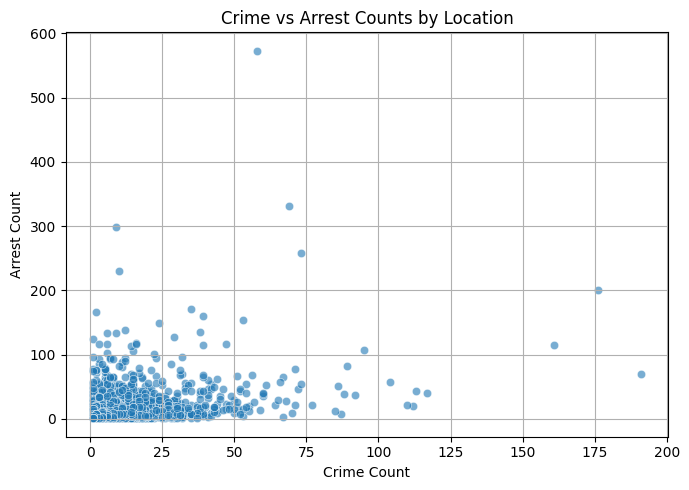


RIPA vs Arrest (geographic):
  Pearson correlation: 0.6844
  Spearman correlation: 0.7880


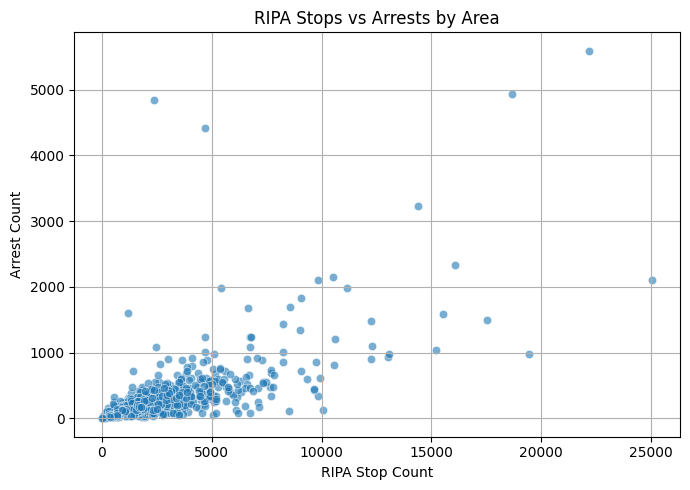

In [9]:
# ============================================
# Cell 9: Correlation Analysis and Visualizations
# ============================================
# This cell evaluates the relationship between crime, arrest, and RIPA stop counts
# using correlation metrics and scatter plots.

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Function to calculate and print correlations
def report_correlation(df, col_x, col_y, label):
    print(f"\n{label}:")
    if col_x not in df.columns or col_y not in df.columns:
        print(f"  Columns {col_x} or {col_y} not found.")
        return

    pearson_corr, _ = pearsonr(df[col_x], df[col_y])
    spearman_corr, _ = spearmanr(df[col_x], df[col_y])

    print(f"  Pearson correlation: {pearson_corr:.4f}")
    print(f"  Spearman correlation: {spearman_corr:.4f}")

# Function to create a scatter plot
def plot_scatter(df, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(7, 5))
    plt.scatter(df[x], df[y], alpha=0.6, edgecolors='w', linewidths=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Crime vs Arrest (Spatial) ---
if crime_arrest_summary is not None:
    report_correlation(crime_arrest_summary, 'crime_count', 'arrest_count', "Crime vs Arrest (spatial)")
    plot_scatter(
        crime_arrest_summary,
        x='crime_count',
        y='arrest_count',
        title='Crime vs Arrest Counts by Location',
        xlabel='Crime Count',
        ylabel='Arrest Count'
    )
else:
    print("crime_arrest_summary is not available.")

# --- RIPA vs Arrest (Geographic) ---
if ripa_arrest_summary is not None:
    report_correlation(ripa_arrest_summary, 'ripa_count', 'arrest_count', "RIPA vs Arrest (geographic)")
    plot_scatter(
        ripa_arrest_summary,
        x='ripa_count',
        y='arrest_count',
        title='RIPA Stops vs Arrests by Area',
        xlabel='RIPA Stop Count',
        ylabel='Arrest Count'
    )
else:
    print("ripa_arrest_summary is not available.")


## Cell 10: Ask LLM to Interpret Correlation Patterns

### Purpose
Provide the LLM with statistical and tabular summaries from previous analysis steps and ask it to interpret the observed patterns between crimes, arrests, and stops.

---

### Inputs
- Correlation coefficients:
  - Pearson and Spearman for:
    - `crime_count` vs `arrest_count` (from `crime_arrest_summary`)
    - `ripa_count` vs `arrest_count` (from `ripa_arrest_summary`)
- First 10 rows of:
  - `crime_arrest_summary`
  - `ripa_arrest_summary`
- `OLLAMA_API_URL` and `LLM_MODEL`

---

### Outputs
- `llm_correlation_analysis_response` (string): LLM-generated insights on what the observed relationships may indicate
- Console output:
  - Confirmation of prompt sent
  - Full LLM response printed to screen

---

### Behavior & Comments
- Construct a clear, plain-English prompt that includes:
  - Context: “We are analyzing counts of crimes, arrests, and police stops”
  - Stats: Correlation coefficients
  - Data samples: 10 rows from each summary table
- Ask the LLM to interpret the meaning of these patterns
- Request suggestions for further statistical or analytical steps
- Handle API errors gracefully

---

### Extensibility Notes
- Can add more context or ask LLM for fairness, policy, or resource allocation interpretations
- Can request follow-up ideas: visualizations, clustering, regression models, etc.


In [10]:
# ============================================
# Cell 10: Ask LLM to Interpret Correlation Patterns
# ============================================
# This cell sends the correlation values and a sample of the aggregated data
# to the LLM and asks it to interpret patterns between crime, arrest, and stop counts.

import requests
import json

# -- Extract correlation metrics from Cell 9 --

# Calculate correlation values again to include in the prompt
def get_correlation_values(df, x, y):
    try:
        pearson_corr, _ = pearsonr(df[x], df[y])
        spearman_corr, _ = spearmanr(df[x], df[y])
        return round(pearson_corr, 4), round(spearman_corr, 4)
    except Exception as e:
        print(f"Error calculating correlation for {x} vs {y}: {e}")
        return None, None

# Calculate correlations
crime_pearson, crime_spearman = get_correlation_values(crime_arrest_summary, 'crime_count', 'arrest_count') \
    if crime_arrest_summary is not None else (None, None)

ripa_pearson, ripa_spearman = get_correlation_values(ripa_arrest_summary, 'ripa_count', 'arrest_count') \
    if ripa_arrest_summary is not None else (None, None)

# Prepare prompt
def build_interpretation_prompt():
    prompt = (
        "You are a statistical analyst helping interpret relationships in law enforcement data.\n\n"
        "We have summarized two pairs of datasets:\n"
        "1. Crime and Arrest counts grouped by location (latitude, longitude, and cross street)\n"
        "2. RIPA Stop and Arrest counts grouped by geographic areas (Area ID, Area Name, Reporting District)\n\n"
        "Here are the correlation results:\n"
    )

    if crime_pearson is not None and crime_spearman is not None:
        prompt += (
            f"- Crime vs Arrest (spatial):\n"
            f"    Pearson: {crime_pearson}\n"
            f"    Spearman: {crime_spearman}\n\n"
        )

    if ripa_pearson is not None and ripa_spearman is not None:
        prompt += (
            f"- RIPA vs Arrest (geographic):\n"
            f"    Pearson: {ripa_pearson}\n"
            f"    Spearman: {ripa_spearman}\n\n"
        )

    prompt += (
        "Here are sample records from the summarized datasets (first 10 rows):\n\n"
        "=== Crime + Arrest Summary ===\n"
    )

    if crime_arrest_summary is not None:
        prompt += crime_arrest_summary.head(10).to_string(index=False)
        prompt += "\n\n"

    prompt += "=== RIPA + Arrest Summary ===\n"

    if ripa_arrest_summary is not None:
        prompt += ripa_arrest_summary.head(10).to_string(index=False)
        prompt += "\n\n"

    prompt += (
        "Please analyze the strength and meaning of these correlations. "
        "What might explain the relationships between crime, arrests, and stops? "
        "Are there any notable patterns or concerns? "
        "What further analysis would you recommend?\n"
    )

    return prompt

# Build prompt
print("Building prompt for LLM interpretation...")
correlation_prompt = build_interpretation_prompt()

# Prepare request
payload = {
    "model": LLM_MODEL,
    "prompt": correlation_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

# Send to Ollama
print("Sending correlation prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_correlation_analysis_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_correlation_analysis_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_correlation_analysis_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing LLM response: {e}")
    llm_correlation_analysis_response = ""


Building prompt for LLM interpretation...
Sending correlation prompt to LLM...

LLM response received:
----------------------------------------
Based on the correlation results, I'll provide an analysis of the relationships between crime, arrests, and stops.

**Correlation Strength**

The Pearson and Spearman correlations suggest a moderate to strong relationship between the variables. However, it's essential to consider the context and potential biases in the data.

* Crime vs Arrest (spatial): The Pearson correlation is 0.4512, indicating a weak to moderate positive relationship. The Spearman correlation is slightly lower at 0.4114. This suggests that while there may be some association between crime and arrest counts at specific locations, it's not extremely strong.
* RIPA vs Arrest (geographic): The Pearson correlation is 0.6844, indicating a moderate to strong positive relationship. The Spearman correlation is even higher at 0.788, suggesting a stronger association between RIPA st

## Cell 11: Linear Regression Analysis

### Purpose
Quantify the strength and nature of the relationship between:
- Crime counts and Arrest counts (per location)
- RIPA stop counts and Arrest counts (per area)

---

### Inputs
- `crime_arrest_summary`: Aggregated by location (with `crime_count`, `arrest_count`)
- `ripa_arrest_summary`: Aggregated by district (with `ripa_count`, `arrest_count`)

---

### Outputs
- Regression summary reports for:
  - `arrest_count ~ crime_count`
  - `arrest_count ~ ripa_count`
- Console output:
  - R², coefficient values, p-values, and model fit information

---

### Behavior & Comments
- Use `statsmodels` for OLS linear regression
- Include intercept in model
- Print model summary and R² to console
- Log interpretation-ready results (e.g., "Each additional crime is associated with X arrests")

---

### Extensibility Notes
- Additional predictors (e.g., population, time period) can be added to model later
- Can switch to Poisson regression for count data if needed
- Residual diagnostics can be added in later steps


In [11]:
# ============================================
# Cell 11: Linear Regression Analysis
# ============================================
# This cell runs basic OLS regression models to quantify the relationship between:
#   - crime_count and arrest_count (spatial data)
#   - ripa_count and arrest_count (geographic data)

import statsmodels.api as sm

# Function to run and summarize a regression model
def run_regression(df, predictor, outcome, label):
    print(f"\nRegression Model: {outcome} ~ {predictor} ({label})")

    # Drop missing values just in case
    df_clean = df[[predictor, outcome]].dropna()

    # Define X (predictor) and y (outcome)
    X = df_clean[[predictor]]
    y = df_clean[outcome]

    # Add constant (intercept) to model
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print regression summary
    print(model.summary())

    # Extract key results
    coef = model.params[predictor]
    pval = model.pvalues[predictor]
    r_squared = model.rsquared

    print(f"\nSummary:")
    print(f"  Coefficient for {predictor}: {coef:.4f}")
    print(f"  p-value: {pval:.4e}")
    print(f"  R-squared: {r_squared:.4f}")

    return model

# Run regression: crime_count → arrest_count
if crime_arrest_summary is not None:
    crime_model = run_regression(
        crime_arrest_summary,
        predictor='crime_count',
        outcome='arrest_count',
        label='Crime + Arrest (spatial)'
    )
else:
    print("crime_arrest_summary not available.")

# Run regression: ripa_count → arrest_count
if ripa_arrest_summary is not None:
    ripa_model = run_regression(
        ripa_arrest_summary,
        predictor='ripa_count',
        outcome='arrest_count',
        label='RIPA + Arrest (geographic)'
    )
else:
    print("ripa_arrest_summary not available.")



Regression Model: arrest_count ~ crime_count (Crime + Arrest (spatial))
                            OLS Regression Results                            
Dep. Variable:           arrest_count   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     6920.
Date:                Thu, 29 May 2025   Prob (F-statistic):               0.00
Time:                        17:55:45   Log-Likelihood:                -93512.
No. Observations:               27072   AIC:                         1.870e+05
Df Residuals:                   27070   BIC:                         1.870e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

## Cell 12: Ask LLM to Explain Regression Results

### Purpose
Provide the LLM with full regression output from linear models and ask it to interpret the results in plain language. This allows dynamic, context-aware explanations based on real data, rather than hardcoded assumptions.

---

### Inputs
- `model.summary().as_text()` from:
  - Crime vs Arrest regression
  - RIPA vs Arrest regression
- Optional labels:
  - Model 1: "Crime → Arrest (spatial)"
  - Model 2: "RIPA → Arrest (geographic)"
- `OLLAMA_API_URL` and `LLM_MODEL`

---

### Outputs
- `llm_regression_interpretation_response` (string): The LLM’s plain-language interpretation of regression results
- Console output:
  - Indication of request sent
  - Display of full LLM response

---

### Behavior & Comments
- Use concise context to explain what the models are estimating
- Include full text output from each model’s `.summary()` (not just coefficients)
- Ask the LLM to:
  - Explain each model’s meaning
  - Comment on statistical significance, fit (R²), and interpretation of coefficients
  - Suggest next steps if needed

---

### Extensibility Notes
- Can add additional predictors later and send updated summaries
- Can ask LLM to assess bias or assumptions (e.g., homoscedasticity)
- May expand to include diagnostic plots or residual analysis


In [12]:
# ============================================
# Cell 12: Ask LLM to Explain Regression Results
# ============================================
# This cell sends the full regression summaries from the previous analysis
# to the LLM and asks for a plain-language interpretation of both models.

import requests
import json

# --- Prepare regression summaries as text ---
crime_regression_text = crime_model.summary().as_text() if 'crime_model' in locals() and crime_model else None
ripa_regression_text = ripa_model.summary().as_text() if 'ripa_model' in locals() and ripa_model else None

# --- Build LLM prompt ---
def build_regression_prompt():
    prompt = (
        "You are a statistical analyst. Below are two linear regression outputs.\n"
        "Each model estimates the relationship between a predictor and arrest counts.\n\n"
    )

    if crime_regression_text:
        prompt += (
            "=== Model 1: Crime → Arrest (spatial grouping by location) ===\n"
            f"{crime_regression_text}\n\n"
        )

    if ripa_regression_text:
        prompt += (
            "=== Model 2: RIPA Stops → Arrest (geographic grouping by area) ===\n"
            f"{ripa_regression_text}\n\n"
        )

    prompt += (
        "Please explain each regression result in plain language:\n"
        "- What does the coefficient mean?\n"
        "- Is the relationship statistically significant?\n"
        "- Is the model a good fit?\n"
        "- What insights or next steps would you recommend based on these outputs?\n"
    )

    return prompt

# --- Build and send prompt ---
print("Building LLM prompt using regression summaries...")
regression_prompt = build_regression_prompt()

payload = {
    "model": LLM_MODEL,
    "prompt": regression_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending regression prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_regression_interpretation_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_regression_interpretation_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_regression_interpretation_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing LLM response: {e}")
    llm_regression_interpretation_response = ""


Building LLM prompt using regression summaries...
Sending regression prompt to LLM...

LLM response received:
----------------------------------------
I'll break down each model's results and provide interpretations in plain language.

**Model 1: Crime → Arrest (spatial grouping by location)**

### Coefficient Meaning
The coefficient for `crime_count` is 0.7225, which means that for every unit increase in crime count at a given location, the arrest count is expected to increase by approximately 0.7225 units.

### Statistical Significance
The p-value for `crime_count` is effectively 0 (p < 0.000), indicating that the relationship between crime count and arrest count is statistically significant. This means we can be confident that the observed effect is not due to chance.

### Model Fit
The R-squared value is approximately 0.204, which indicates that about 20% of the variation in arrest counts can be explained by the model. While this might seem low, it's still a reasonable fit consider

## Cell 13: Geospatial Analysis (Heatmap and Point Clusters)

### Purpose
Visualize the spatial distribution of crimes and arrests using latitude/longitude data. Identify geographic clusters or outliers in activity.

---

### Inputs
- `crime_arrest_summary`: Includes `LAT`, `LON`, `crime_count`, `arrest_count`

---

### Outputs
- Interactive map showing:
  - Heatmap of total activity (crime + arrests)
  - Optional: individual points with count tooltips

---

### Behavior & Comments
- Use `folium.Map` to display data centered on average coordinates
- Normalize or scale markers by total activity
- Tooltip or popup shows underlying data
- Can add base layers or toggle layers later

---

### Extensibility Notes
- Can include choropleths using neighborhood boundaries
- Can layer time-based animations
- Can filter by threshold (e.g., show only top 5% of locations)


In [13]:
# ============================================
# Cell 13: Geospatial Analysis with Folium
# ============================================
# This cell uses folium to display an interactive map of the spatial summary data.
# Points are sized or colored by total activity (crime + arrests), with tooltips for detail.

import folium
from folium.plugins import HeatMap
import numpy as np

# --- Verify and prepare input data ---
if crime_arrest_summary is None:
    print("crime_arrest_summary is not available.")
else:
    # Calculate total activity as a visual weight
    crime_arrest_summary['total_activity'] = (
        crime_arrest_summary['crime_count'] + crime_arrest_summary['arrest_count']
    )

    # Filter out any rows missing lat/lon
    geo_data = crime_arrest_summary.dropna(subset=['LAT', 'LON'])

    # Optional: Filter to top 5% most active locations to reduce clutter
    activity_threshold = np.percentile(geo_data['total_activity'], 95)
    geo_data = geo_data[geo_data['total_activity'] >= activity_threshold]

    # Center map on average location
    lat_center = geo_data['LAT'].mean()
    lon_center = geo_data['LON'].mean()

    m = folium.Map(location=[lat_center, lon_center], zoom_start=11, tiles='CartoDB positron')

    # Add points with tooltips
    for _, row in geo_data.iterrows():
        tooltip = (
            f"Cross Street: {row['Cross Street']}<br>"
            f"Crimes: {row['crime_count']}<br>"
            f"Arrests: {row['arrest_count']}"
        )
        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=min(10, row['total_activity']**0.5),  # Scaled size
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            popup=folium.Popup(tooltip, max_width=250)
        ).add_to(m)

    # Optional heatmap overlay (toggle on/off as needed)
    heat_data = geo_data[['LAT', 'LON', 'total_activity']].values.tolist()
    HeatMap(heat_data, radius=15, blur=12, min_opacity=0.4).add_to(m)

    print("Interactive map generated. Scroll and zoom to explore:")
    display(m)


Interactive map generated. Scroll and zoom to explore:


## Cell 14: Weather + Arrest Correlation (Top 25 Days)

### Purpose
Investigate whether there is a correlation between daily arrest counts and temperature by:
- Identifying the top 25 days with the highest number of arrests
- Fetching historical temperature data for those dates
- Correlating temperature with arrest volume

---

### Inputs
- `arrest_df`: Full arrest dataset (must include a date column, e.g., `ARREST_DATE`)
- Location: Default to Los Angeles, CA
- Weather source: Open-Meteo historical API (no API key required)

---

### Outputs
- `top_arrest_days`: DataFrame of the top 25 arrest days with date and count
- `arrest_weather_data`: Merged DataFrame with arrest count and temperature per day
- Correlation statistics between arrest count and temperature
- Console output:
  - Dates being queried
  - Success/failure of API calls
  - Summary of results

---

### Behavior & Comments
- Group arrests by date, sort by count descending
- Query Open-Meteo’s historical endpoint for each date
- Extract daily max or average temperature (Celsius or Fahrenheit)
- Merge weather data with arrest counts
- Run correlation analysis between temperature and arrest count

---

### Extensibility Notes
- Could expand to precipitation, humidity, or air quality
- May support bulk API queries if available
- Could be visualized with scatter + trendline or time series


In [14]:
# ============================================
# Cell 14: Weather + Arrest Correlation (Top 25 Days)
# ============================================
# This cell identifies the top 25 days with the most arrests,
# fetches historical temperature data for Los Angeles from Open-Meteo,
# and calculates correlation between temperature and arrest counts.

import requests
import pandas as pd
from datetime import datetime
from scipy.stats import pearsonr, spearmanr

# Configuration
OPEN_METEO_URL = "https://archive-api.open-meteo.com/v1/archive"
LAT = 34.0522    # Los Angeles latitude
LON = -118.2437  # Los Angeles longitude

# ============================================
# Cell 14 (patched): Handle arrest date column
# ============================================

# Rename 'Arrest Date' to 'ARREST_DATE' for consistency
if 'Arrest Date' in arrest_df.columns:
    arrest_df = arrest_df.rename(columns={'Arrest Date': 'ARREST_DATE'})
    arrest_df['ARREST_DATE'] = pd.to_datetime(arrest_df['ARREST_DATE'], errors='coerce')
else:
    raise ValueError("Expected 'Arrest Date' column not found in arrest_df.")


# Step 1: Get top 25 days with most arrests
top_arrest_days = (
    arrest_df
    .groupby('ARREST_DATE')
    .size()
    .reset_index(name='arrest_count')
    .sort_values(by='arrest_count', ascending=False)
    .head(25)
)

print("Top 25 arrest days:")
display(top_arrest_days)

# Step 2: Fetch weather for each day
def fetch_temperature(date):
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": date.strftime("%Y-%m-%d"),
        "end_date": date.strftime("%Y-%m-%d"),
        "daily": "temperature_2m_max",
        "temperature_unit": "fahrenheit",
        "timezone": "America/Los_Angeles"
    }
    try:
        response = requests.get(OPEN_METEO_URL, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data['daily']['temperature_2m_max'][0]
    except Exception as e:
        print(f"Failed to fetch weather for {date.date()}: {e}")
        return None

# Step 3: Add temperature to the top_arrest_days
print("\nFetching temperatures for top arrest days...")
top_arrest_days['temperature_f'] = top_arrest_days['ARREST_DATE'].apply(fetch_temperature)

# Drop rows where temperature couldn't be fetched
arrest_weather_data = top_arrest_days.dropna(subset=['temperature_f'])

# Step 4: Correlation analysis
pearson_corr, _ = pearsonr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])
spearman_corr, _ = spearmanr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])

print("\nCorrelation between temperature and arrest count:")
print(f"  Pearson correlation: {pearson_corr:.4f}")
print(f"  Spearman correlation: {spearman_corr:.4f}")

# Optional: display merged table
print("\nTop arrest days with temperature:")
display(arrest_weather_data)


Top 25 arrest days:


/tmp/ipykernel_70365/3985014872.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  arrest_df['ARREST_DATE'] = pd.to_datetime(arrest_df['ARREST_DATE'], errors='coerce')


,ARREST_DATE,arrest_count
1268,2023-06-22,426
152,2020-06-01,362
449,2021-03-25,342
54,2020-02-24,317
22,2020-01-23,315
1400,2023-11-01,314
1206,2023-04-21,313
1402,2023-11-03,304
1226,2023-05-11,302
28,2020-01-29,299



Fetching temperatures for top arrest days...
Failed to fetch weather for 2023-11-01: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2023-04-21: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2024-08-09: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2020-01-30: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2020-02-13: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2020-02-28: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)

Correlation between temperature and arrest count:
  Pearson correlation: -0.0597
  Spearman correlation: -0.2770


,ARREST_DATE,arrest_count,temperature_f
1268,2023-06-22,426,74.4
152,2020-06-01,362,88.8
449,2021-03-25,342,62.9
54,2020-02-24,317,67.0
22,2020-01-23,315,72.1
1402,2023-11-03,304,84.9
1226,2023-05-11,302,71.0
28,2020-01-29,299,74.1
1231,2023-05-16,296,73.3
49,2020-02-19,296,69.6


## Cell 15: Ask LLM to Explain Temperature vs Arrests

### Purpose
Provide the LLM with analysis results relating weather (daily max temperature) to arrest volume. Ask for an interpretation of whether any relationship exists and how to improve or extend the analysis.

---

### Inputs
- Correlation values:
  - Pearson and Spearman correlation between `temperature_f` and `arrest_count`
- Data sample:
  - `arrest_weather_data.head(25)`: Top 25 days by arrest count with temperatures
- Context:
  - This analysis is limited to one city and one weather variable (daily max temperature)

---

### Outputs
- `llm_weather_analysis_response`: The LLM’s interpretation of the relationship (or lack thereof) between temperature and arrests
- Console output:
  - Display of full response

---

### Behavior & Comments
- Provide correlation stats and sample data to support interpretation
- Ask the LLM to:
  - Explain if a relationship exists
  - Evaluate strength of the pattern
  - Recommend improvements (e.g., alternative weather variables, longer time windows, confounders)
- Avoid hardcoded assumptions about climate (let LLM reason from data)

---

### Extensibility Notes
- Can add time-of-day, precipitation, or humidity
- Could ask LLM to design a full model or fairness-aware analysis


In [15]:
# ============================================
# Cell 15: Ask LLM to Explain Temperature vs Arrests
# ============================================
# This cell sends the temperature-arrest data and correlation results
# to the LLM and asks for an interpretation of the findings.

import requests
import json

# --- Recalculate correlation if needed ---
try:
    pearson_corr, _ = pearsonr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])
    spearman_corr, _ = spearmanr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])
except Exception as e:
    print(f"Error computing correlations: {e}")
    pearson_corr = None
    spearman_corr = None

# --- Build prompt for LLM ---
def build_weather_prompt():
    prompt = (
        "You are a data analyst helping to interpret whether temperature affects arrest volume.\n\n"
        "The analysis looked at the 25 days with the highest arrest counts in Los Angeles.\n"
        "For each day, the maximum daily temperature (in Fahrenheit) was retrieved using Open-Meteo.\n\n"
        "Here are the correlation results:\n"
        f"- Pearson correlation: {pearson_corr:.4f}\n"
        f"- Spearman correlation: {spearman_corr:.4f}\n\n"
        "Here are the arrest counts and temperatures for the top 25 days:\n\n"
    )

    prompt += arrest_weather_data[['ARREST_DATE', 'arrest_count', 'temperature_f']].to_string(index=False)
    prompt += "\n\n"

    prompt += (
        "Please interpret the relationship between temperature and arrest counts:\n"
        "- Is there a meaningful correlation?\n"
        "- What might explain the observed pattern?\n"
        "- Are there better weather or contextual variables we should test?\n"
        "- What limitations does this analysis have?\n"
    )

    return prompt

# Build and send prompt
print("Building LLM prompt with temperature-arrest data...")
weather_prompt = build_weather_prompt()

payload = {
    "model": LLM_MODEL,
    "prompt": weather_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending temperature correlation prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_weather_analysis_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_weather_analysis_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_weather_analysis_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing LLM response: {e}")
    llm_weather_analysis_response = ""


Building LLM prompt with temperature-arrest data...
Sending temperature correlation prompt to LLM...

LLM response received:
----------------------------------------
**Interpretation of results**

The correlation analysis suggests that there is a weak to moderate negative relationship between temperature and arrest counts in Los Angeles. However, it's essential to consider the following:

* The Pearson correlation coefficient (-0.0597) indicates a very weak negative linear relationship between temperature and arrest counts.
* The Spearman correlation coefficient (-0.2770) suggests a moderate negative non-linear relationship.

Considering both coefficients, the overall trend is that as temperatures increase (or decrease), arrest counts tend to decrease (or increase). However, this pattern might not be consistent across all days, and there may be other factors at play.

**Explaining the observed pattern**

There are several possible explanations for the observed negative correlation:

1.

## Same but with 100 days

In [16]:
# ============================================
# Cell 14: Weather + Arrest Correlation (Top 25 Days)
# ============================================
# This cell identifies the top 100 days with the most arrests,
# fetches historical temperature data for Los Angeles from Open-Meteo,
# and calculates correlation between temperature and arrest counts.

import requests
import pandas as pd
from datetime import datetime
from scipy.stats import pearsonr, spearmanr

# Configuration
OPEN_METEO_URL = "https://archive-api.open-meteo.com/v1/archive"
LAT = 34.0522    # Los Angeles latitude
LON = -118.2437  # Los Angeles longitude

# ============================================
# Cell 14 (patched): Handle arrest date column
# ============================================

# Rename and normalize the arrest date column only once
if 'Arrest Date' in arrest_df.columns:
    arrest_df = arrest_df.rename(columns={'Arrest Date': 'ARREST_DATE'})

# Check that 'ARREST_DATE' now exists
if 'ARREST_DATE' not in arrest_df.columns:
    raise ValueError("Expected 'ARREST_DATE' column not found in arrest_df.")

# Ensure datetime format
arrest_df['ARREST_DATE'] = pd.to_datetime(arrest_df['ARREST_DATE'], errors='coerce')



# Step 1: Get top 25 days with most arrests
top_arrest_days = (
    arrest_df
    .groupby('ARREST_DATE')
    .size()
    .reset_index(name='arrest_count')
    .sort_values(by='arrest_count', ascending=False)
    .head(100)
)

print("Top 100 arrest days:")
display(top_arrest_days)

# Step 2: Fetch weather for each day
def fetch_temperature(date):
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": date.strftime("%Y-%m-%d"),
        "end_date": date.strftime("%Y-%m-%d"),
        "daily": "temperature_2m_max",
        "temperature_unit": "fahrenheit",
        "timezone": "America/Los_Angeles"
    }
    try:
        response = requests.get(OPEN_METEO_URL, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data['daily']['temperature_2m_max'][0]
    except Exception as e:
        print(f"Failed to fetch weather for {date.date()}: {e}")
        return None

# Step 3: Add temperature to the top_arrest_days
print("\nFetching temperatures for top arrest days...")
top_arrest_days['temperature_f'] = top_arrest_days['ARREST_DATE'].apply(fetch_temperature)

# Drop rows where temperature couldn't be fetched
arrest_weather_data = top_arrest_days.dropna(subset=['temperature_f'])

# Step 4: Correlation analysis
pearson_corr, _ = pearsonr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])
spearman_corr, _ = spearmanr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])

print("\nCorrelation between temperature and arrest count:")
print(f"  Pearson correlation: {pearson_corr:.4f}")
print(f"  Spearman correlation: {spearman_corr:.4f}")

# Optional: display merged table
print("\nTop arrest days with temperature:")
display(arrest_weather_data)


Top 100 arrest days:


,ARREST_DATE,arrest_count
1268,2023-06-22,426
152,2020-06-01,362
449,2021-03-25,342
54,2020-02-24,317
22,2020-01-23,315
...,...,...
642,2021-10-04,246
1493,2024-02-02,246
1234,2023-05-19,246
55,2020-02-25,246



Fetching temperatures for top arrest days...
Failed to fetch weather for 2020-01-23: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2020-02-19: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2020-03-11: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2020-01-31: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2024-08-15: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2022-09-09: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read timed out. (read timeout=10)
Failed to fetch weather for 2024-12-11: HTTPSConnectionPool(host='archive-api.open-meteo.com', port=443): Read tim

,ARREST_DATE,arrest_count,temperature_f
1268,2023-06-22,426,74.4
152,2020-06-01,362,88.8
449,2021-03-25,342,62.9
54,2020-02-24,317,67.0
1400,2023-11-01,314,86.0
...,...,...,...
1584,2024-05-03,246,73.3
642,2021-10-04,246,87.8
1493,2024-02-02,246,61.2
1234,2023-05-19,246,74.8


## Ask the LLM to analyze

In [17]:
# ============================================
# Cell 15: Ask LLM to Explain Temperature vs Arrests
# ============================================
# This cell sends the temperature-arrest data and correlation results
# to the LLM and asks for an interpretation of the findings.

import requests
import json

# --- Recalculate correlation if needed ---
try:
    pearson_corr, _ = pearsonr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])
    spearman_corr, _ = spearmanr(arrest_weather_data['temperature_f'], arrest_weather_data['arrest_count'])
except Exception as e:
    print(f"Error computing correlations: {e}")
    pearson_corr = None
    spearman_corr = None

# --- Build prompt for LLM ---
def build_weather_prompt():
    prompt = (
        "You are a data analyst helping to interpret whether temperature affects arrest volume.\n\n"
        "The analysis looked at the 100 days with the highest arrest counts in Los Angeles.\n"
        "For each day, the maximum daily temperature (in Fahrenheit) was retrieved using Open-Meteo.\n\n"
        "Here are the correlation results:\n"
        f"- Pearson correlation: {pearson_corr:.4f}\n"
        f"- Spearman correlation: {spearman_corr:.4f}\n\n"
        "Here are the arrest counts and temperatures for the top 100 days:\n\n"
    )

    prompt += arrest_weather_data[['ARREST_DATE', 'arrest_count', 'temperature_f']].to_string(index=False)
    prompt += "\n\n"

    prompt += (
        "Please interpret the relationship between temperature and arrest counts:\n"
        "- Is there a meaningful correlation?\n"
        "- What might explain the observed pattern?\n"
        "- Are there better weather or contextual variables we should test?\n"
        "- What limitations does this analysis have?\n"
    )

    return prompt

# Build and send prompt
print("Building LLM prompt with temperature-arrest data...")
weather_prompt = build_weather_prompt()

payload = {
    "model": LLM_MODEL,
    "prompt": weather_prompt,
    "stream": False
}

headers = {"Content-Type": "application/json"}

print("Sending temperature correlation prompt to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_weather_analysis_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_weather_analysis_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_weather_analysis_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing LLM response: {e}")
    llm_weather_analysis_response = ""


Building LLM prompt with temperature-arrest data...
Sending temperature correlation prompt to LLM...

LLM response received:
----------------------------------------
Based on the provided data and analysis, here's my interpretation of the relationship between temperature and arrest counts:

**Meaningful Correlation?**

The Pearson correlation coefficient is -0.0398, indicating a weak negative correlation between temperature and arrest counts. The Spearman correlation coefficient is even weaker at -0.0221. While the correlations are statistically significant (p-value < 0.01 for both), the coefficients themselves are very small. This suggests that there is no strong or meaningful relationship between temperature and arrest counts.

**Observed Pattern**

Upon closer inspection, it appears that the data points with high arrest counts tend to cluster around temperatures in the mid-70s to low 80s Fahrenheit (°F). There are fewer arrests when temperatures are extremely hot (>95°F) or cold (<6

## Cell 16: Analyze Nighttime Crime on Full Moon Nights

### Purpose
Determine whether full moon nights (6PM–6AM) are associated with higher or different crime patterns than other nights by:
- Computing full moon dates
- Filtering crimes to nighttime hours around full moons
- Comparing crime counts to non-full moon nights

---

### Inputs
- `crime_df`: The crime dataset, must include:
  - A date column (e.g., `DATE_OCC`)
  - A time column (e.g., `TIME_OCC`) in HHMM format or string
- Date range: Based on available data
- Full moon calculation: Use `ephem` to generate full moon dates

---

### Outputs
- DataFrames:
  - `night_crimes`: All crimes between 6PM–6AM (any night)
  - `full_moon_night_crimes`: Crimes on full moon nights
- Summary stats:
  - Number of crimes on full moon nights vs other nights
  - Optional: crime type breakdown, hourly distribution
- Console output:
  - Number of full moon nights covered
  - Counts of full moon vs non-full moon crimes

---

### Behavior & Comments
- Define "full moon night" as:
  - 6:00 PM–11:59 PM on full moon date
  - 12:00 AM–5:59 AM on the next calendar date
- Handle time data reliably even if string or integer
- Allow comparisons or plots to follow in later steps

---

### Extensibility Notes
- Can compare by crime type or geography
- May support significance testing (e.g., chi-square)
- Could expand to other moon phases or lunar cycles


/tmp/ipykernel_70365/829686100.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_df[DATE_COL] = pd.to_datetime(crime_df[DATE_COL], errors='coerce')


Calculated 66 full moon dates.

--- Full Moon Crime Summary ---
Total nighttime crimes:         467805
  On full moon nights:          15699 crimes over 128 nights
  On non-full moon nights:      452106 crimes over 1739 nights
  Rate per night (full moon):   122.65
  Rate per night (non-full):    259.98


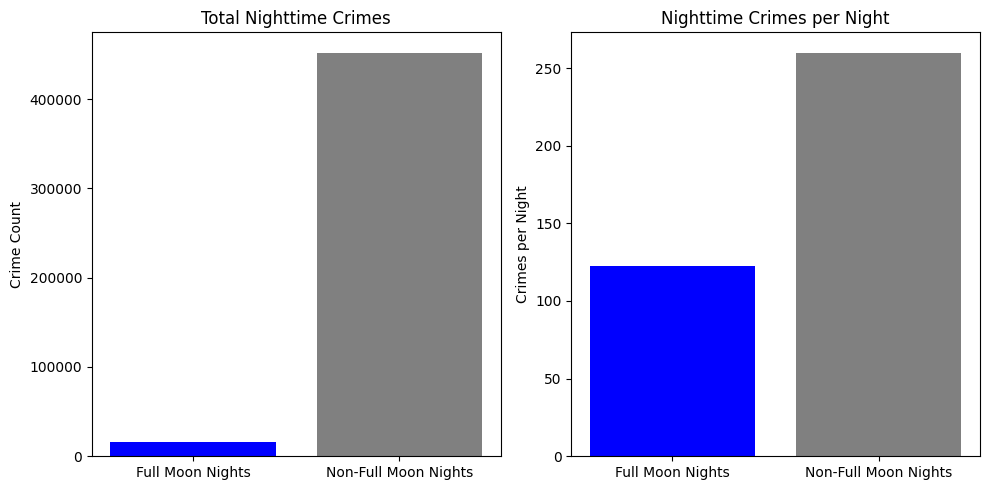


Chi-square test result:
  chi² = 5986.3608
  p-value = 0.0000
  → Statistically significant difference in crime rates (p < 0.05).


In [18]:
# ============================================
# Cell 16: Full Moon Nighttime Crime Analysis with Comparison Chart
# ============================================
# This cell calculates full moon dates using ephem, filters nighttime crimes (6PM–6AM),
# compares full moon vs non-full moon nights, and plots the results.

import ephem
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# --- Configuration ---
DATE_COL = 'DATE OCC'    # Update to match your dataset
TIME_COL = 'TIME OCC'    # Should be HHMM format as int or string

# Ensure correct types
crime_df[DATE_COL] = pd.to_datetime(crime_df[DATE_COL], errors='coerce')

# Convert time to military format HHMM (as int)
def parse_time(value):
    try:
        value = str(int(value)).zfill(4)
        hour = int(value[:2])
        minute = int(value[2:])
        return hour * 100 + minute
    except:
        return None

crime_df[TIME_COL] = crime_df[TIME_COL].apply(parse_time)
crime_df = crime_df.dropna(subset=[DATE_COL, TIME_COL])

# --- Step 1: Generate full moon dates using ephem ---
start_date = crime_df[DATE_COL].min().date()
end_date = crime_df[DATE_COL].max().date()

full_moon_dates = []
moon = ephem.Moon()
d = ephem.Date(start_date)

while ephem.Date(d).datetime().date() <= end_date:
    full = ephem.next_full_moon(d)
    full_moon_dates.append(full.datetime().date())
    d = full + 1

print(f"Calculated {len(full_moon_dates)} full moon dates.")

# --- Step 2: Flag crimes during 6PM–6AM around full moon dates ---
def is_full_moon_night(row):
    date = row[DATE_COL].date()
    time = row[TIME_COL]
    if date in full_moon_dates and time >= 1800:
        return True
    if (date - timedelta(days=1)) in full_moon_dates and time < 600:
        return True
    return False

crime_df['is_nighttime'] = crime_df[TIME_COL].between(1800, 2359) | crime_df[TIME_COL].between(0, 559)
crime_df['is_full_moon_night'] = crime_df.apply(is_full_moon_night, axis=1)

# --- Step 3: Filter and group data ---
night_crimes = crime_df[crime_df['is_nighttime']]
full_moon_night_crimes = night_crimes[night_crimes['is_full_moon_night']]
non_full_moon_night_crimes = night_crimes[~night_crimes['is_full_moon_night']]

# --- Step 4: Count nights in each group ---
full_moon_nights = set()
non_full_moon_nights = set()

for date in full_moon_dates:
    full_moon_nights.add(date)
    full_moon_nights.add(date + timedelta(days=1))

all_night_dates = set(night_crimes[DATE_COL].dt.date.unique())
non_full_moon_nights = all_night_dates - full_moon_nights

n_full_moon_nights = len(full_moon_nights & all_night_dates)
n_non_full_moon_nights = len(non_full_moon_nights)

# --- Step 5: Totals and normalized rates ---
count_full = len(full_moon_night_crimes)
count_non = len(non_full_moon_night_crimes)

rate_full = count_full / n_full_moon_nights if n_full_moon_nights else 0
rate_non = count_non / n_non_full_moon_nights if n_non_full_moon_nights else 0

print("\n--- Full Moon Crime Summary ---")
print(f"Total nighttime crimes:         {len(night_crimes)}")
print(f"  On full moon nights:          {count_full} crimes over {n_full_moon_nights} nights")
print(f"  On non-full moon nights:      {count_non} crimes over {n_non_full_moon_nights} nights")
print(f"  Rate per night (full moon):   {rate_full:.2f}")
print(f"  Rate per night (non-full):    {rate_non:.2f}")

# --- Step 6: Bar Chart ---
labels = ['Full Moon Nights', 'Non-Full Moon Nights']
counts = [count_full, count_non]
rates = [rate_full, rate_non]

plt.figure(figsize=(10, 5))

# Total crimes
plt.subplot(1, 2, 1)
plt.bar(labels, counts, color=['blue', 'gray'])
plt.title('Total Nighttime Crimes')
plt.ylabel('Crime Count')

# Crimes per night
plt.subplot(1, 2, 2)
plt.bar(labels, rates, color=['blue', 'gray'])
plt.title('Nighttime Crimes per Night')
plt.ylabel('Crimes per Night')

plt.tight_layout()
plt.show()

# --- Step 7: Chi-square test ---
observed = [count_full, count_non]
expected_full = rate_non * n_full_moon_nights
expected_non = rate_non * n_non_full_moon_nights
expected = [expected_full, expected_non]

chi2, p, _, _ = chi2_contingency([observed, expected])

print("\nChi-square test result:")
print(f"  chi² = {chi2:.4f}")
print(f"  p-value = {p:.4f}")
if p < 0.05:
    print("  → Statistically significant difference in crime rates (p < 0.05).")
else:
    print("  → No statistically significant difference (p ≥ 0.05).")


## Cell 17: Ask LLM to Interpret Full Moon Crime Pattern

### Purpose
Send the LLM a summary of the full moon vs nighttime crime comparison, including statistics and test results, and ask for an interpretation of whether a meaningful relationship exists.

---

### Inputs
- Total crime counts:
  - `full_moon_crime_count`, `non_full_moon_crime_count`
- Number of nights in each group:
  - `n_full_moon_nights`, `n_non_full_moon_nights`
- Normalized rates (crimes per night)
- Chi-square test results:
  - `chi²`, `p-value`
- Optional: percentage share of total crime from full moon nights

---

### Outputs
- `llm_moon_analysis_response`: LLM-generated explanation of the results
- Console output with full interpretation

---

### Behavior & Comments
- Frame the question clearly: "Does the full moon affect crime rates at night?"
- Ask LLM to explain whether the results are statistically significant
- Ask whether the effect is meaningful, and how the analysis might be improved

---

### Extensibility Notes
- Can include crime types or hourly breakdowns later
- Could test other lunar phases (e.g., new moon, waxing, waning)


In [19]:
# ============================================
# Cell 17: Ask LLM to Interpret Full Moon Crime Pattern
# ============================================
# This cell sends the full moon night vs non-full moon night crime stats
# to the LLM and asks for an interpretation of the observed patterns.

import requests
import json

# --- Build prompt for the LLM ---
def build_full_moon_prompt():
    prompt = (
        "You are a statistical analyst reviewing whether full moon nights affect crime rates.\n\n"
        "The dataset consists of nighttime crimes (6PM–6AM).\n"
        "The nights were split into two groups:\n"
        "- Full moon nights (the night of the full moon and the following early morning)\n"
        "- All other nights\n\n"
        "Here are the results:\n"
        f"- Full moon nights: {n_full_moon_nights} nights, {count_full} crimes\n"
        f"- Non-full moon nights: {n_non_full_moon_nights} nights, {count_non} crimes\n"
        f"- Crime rate on full moon nights: {rate_full:.2f} crimes per night\n"
        f"- Crime rate on non-full moon nights: {rate_non:.2f} crimes per night\n\n"
        "Statistical test:\n"
        f"- Chi-square test: chi² = {chi2:.4f}, p-value = {p:.4f}\n\n"
        "Please answer the following:\n"
        "- Is there a meaningful or statistically significant relationship?\n"
        "- What does the p-value suggest?\n"
        "- Are the differences in crime rates important?\n"
        "- What would you recommend as next steps for further investigation?\n"
    )
    return prompt

# Prepare and send request
prompt = build_full_moon_prompt()
payload = {
    "model": LLM_MODEL,
    "prompt": prompt,
    "stream": False
}
headers = {"Content-Type": "application/json"}

print("Sending full moon crime summary to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_moon_analysis_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_moon_analysis_response)
    print("-" * 40)

except requests.exceptions.RequestException as e:
    print(f"Error contacting LLM API: {e}")
    llm_moon_analysis_response = ""

except (ValueError, KeyError) as e:
    print(f"Error parsing LLM response: {e}")
    llm_moon_analysis_response = ""


Sending full moon crime summary to LLM...

LLM response received:
----------------------------------------
**Is there a meaningful or statistically significant relationship?**

Yes, the Chi-square test indicates that there is a statistically significant relationship between full moon nights and crime rates. The extremely low p-value (p = 0.0000) suggests that the observed difference in crime rates between full moon and non-full moon nights is unlikely to occur by chance.

**What does the p-value suggest?**

The p-value of 0.0000 indicates that the probability of observing such a large difference in crime rates, or a more extreme one, under the null hypothesis (i.e., no association between full moon nights and crime rates) is extremely low, essentially zero. This suggests strong evidence against the null hypothesis, supporting the conclusion that there is a statistically significant relationship between full moon nights and crime rates.

**Are the differences in crime rates important?**

### Using this suggestion3.  
**Consider a more nuanced analysis**: Instead of relying solely on the chi-square test, consider using regression models to account for the complex relationships between multiple variables and explore potential interactions.

## Logistic Regression – Full Moon Crime Predictor Top 10

### Purpose
Fit a logistic regression model to predict whether a crime occurred on a full moon night based on contextual features like hour of occurrence, weekday, and crime type. This allows for a more nuanced, multivariable understanding of what influences full moon night crime rates.


In [20]:
print(crime_df.columns.tolist())

['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON', 'is_nighttime', 'is_full_moon_night']


Preparing features and visualizing crime type distribution...
Total unique crime types (including None): 138


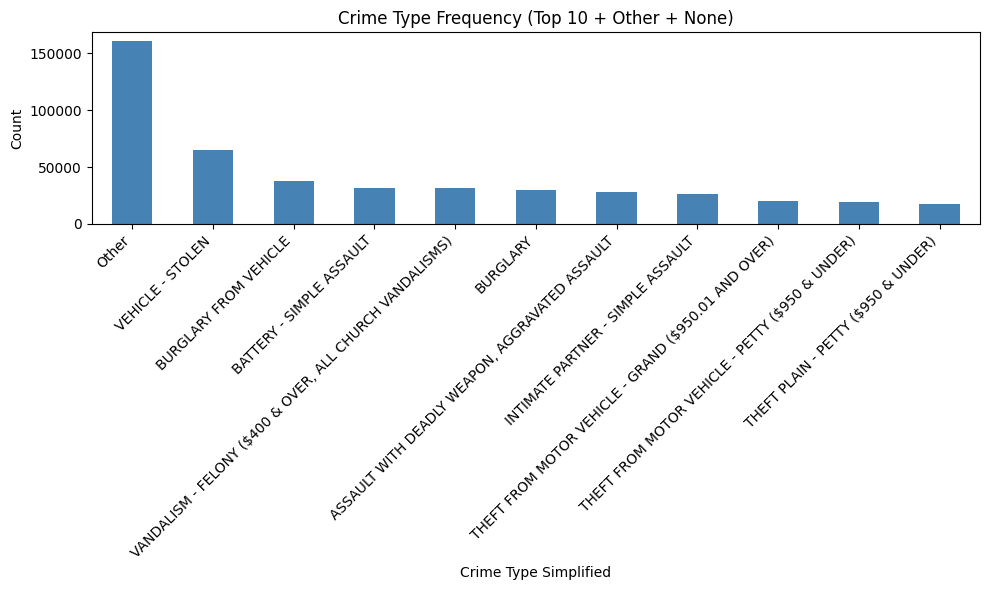

Preparing data for regression...
Fitting logistic regression model...

Model Summary:
                           Logit Regression Results                           
Dep. Variable:     is_full_moon_night   No. Observations:               467805
Model:                          Logit   Df Residuals:                   467792
Method:                           MLE   Df Model:                           12
Date:                Thu, 29 May 2025   Pseudo R-squ.:               0.0002487
Time:                        18:01:59   Log-Likelihood:                -68705.
converged:                       True   LL-Null:                       -68722.
Covariance Type:            nonrobust   LLR p-value:                 0.0006299
                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------

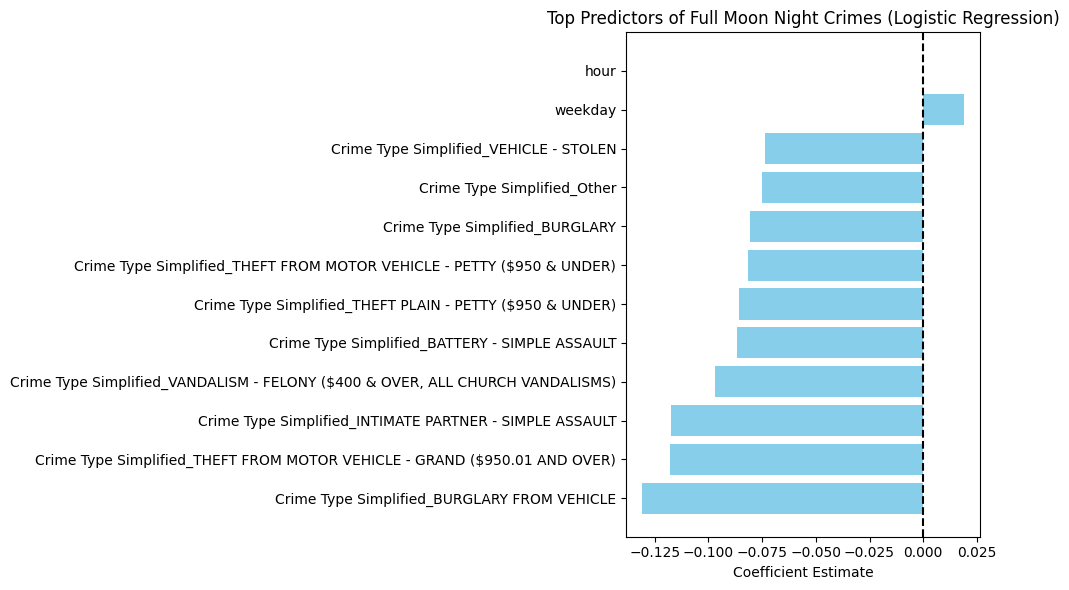

In [21]:
# ============================================
# Cell 18 (updated): Crime Type Frequency & Regression Prep
# ============================================
# This version includes a frequency chart of all crime types (incl. None),
# simplifies to top 10 for modeling, and prepares data for logistic regression.

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Step 1: Feature Engineering & Simplification ---
print("Preparing features and visualizing crime type distribution...")

# Copy to avoid modifying original
df = night_crimes.copy()

# Count total unique crime types (including NaNs)
unique_crime_types = df['Crm Cd Desc'].nunique(dropna=False)
print(f"Total unique crime types (including None): {unique_crime_types}")

# Fill NaNs with 'None' string for grouping
df['crime_type_filled'] = df['Crm Cd Desc'].fillna('None')

# Get top 10 most common crime types
top_crimes = df['crime_type_filled'].value_counts().nlargest(10)
top_crime_names = top_crimes.index.tolist()

# Create a column that groups others as 'Other'
df['Crime Type Simplified'] = df['crime_type_filled'].apply(
    lambda x: x if x in top_crime_names else 'Other'
)

# Plot top 10 + Other + None frequencies
freq_counts = df['Crime Type Simplified'].value_counts()
plt.figure(figsize=(10, 6))
freq_counts.plot(kind='bar', color='steelblue')
plt.title('Crime Type Frequency (Top 10 + Other + None)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- Step 2: Prepare for Logistic Regression ---
print("Preparing data for regression...")

# Extract hour and weekday
def extract_hour(value):
    try:
        return int(str(int(value)).zfill(4)[:2])
    except:
        return np.nan

df['hour'] = df['TIME OCC'].apply(extract_hour)
df['weekday'] = df['DATE OCC'].dt.weekday

# Filter down to clean data
model_df = df[['is_full_moon_night', 'hour', 'weekday', 'Crime Type Simplified']].dropna()

# One-hot encode predictors
X = pd.get_dummies(model_df[['hour', 'weekday', 'Crime Type Simplified']], drop_first=True)
y = model_df['is_full_moon_night'].astype(int)

# Add intercept and convert to float
X = sm.add_constant(X)
X = X.astype(float)

# --- Step 3: Fit Logistic Regression ---
print("Fitting logistic regression model...")
model = sm.Logit(y, X).fit(disp=0)

# --- Step 4: Model Summary ---
print("\nModel Summary:")
print(model.summary())

# --- Step 5: Plot Top Coefficients ---
print("\nTop predictors by effect size:")
coef = model.params
conf = model.conf_int()
summary_df = pd.DataFrame({
    'coef': coef,
    'lower': conf[0],
    'upper': conf[1]
})
summary_df = summary_df.drop('const', errors='ignore')
summary_df['abs_coef'] = summary_df['coef'].abs()

top_predictors = summary_df.sort_values('abs_coef', ascending=False).head(15)

# Plot top predictors
plt.figure(figsize=(10, 6))
plt.barh(top_predictors.index, top_predictors['coef'], color='skyblue')
plt.axvline(0, color='black', linestyle='--')
plt.title('Top Predictors of Full Moon Night Crimes (Logistic Regression)')
plt.xlabel('Coefficient Estimate')
plt.tight_layout()
plt.show()


## Crime summaries  

In [22]:
# ============================================
# Cell 19: Crime Type Frequency Table
# ============================================
# This cell creates a frequency table of all crime types, including missing (None) values.

# Fill NaNs with string label for grouping
crime_type_counts = (
    crime_df['Crm Cd Desc']
    .fillna('None')
    .value_counts(dropna=False)
    .reset_index()
)

crime_type_counts.columns = ['Crime Type', 'Count']

# Display the top rows
print(f"Total unique crime types (including None): {crime_type_counts.shape[0]}")
# Display the frequency table (top rows)
print(f"Total unique crime types (including None): {crime_type_counts.shape[0]}")
display(crime_type_counts)


Total unique crime types (including None): 140
Total unique crime types (including None): 140


,Crime Type,Count
0,VEHICLE - STOLEN,115238
1,BATTERY - SIMPLE ASSAULT,74842
2,BURGLARY FROM VEHICLE,63518
3,THEFT OF IDENTITY,62539
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",61094
...,...,...
135,FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS ...,5
136,FIREARMS RESTRAINING ORDER (FIREARMS RO),4
137,DISHONEST EMPLOYEE ATTEMPTED THEFT,4
138,TRAIN WRECKING,1


In [23]:
pd.set_option('display.max_rows', 150)
display(crime_type_counts)


,Crime Type,Count
0,VEHICLE - STOLEN,115238
1,BATTERY - SIMPLE ASSAULT,74842
2,BURGLARY FROM VEHICLE,63518
3,THEFT OF IDENTITY,62539
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",61094
5,BURGLARY,57875
6,THEFT PLAIN - PETTY ($950 & UNDER),53718
7,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",53528
8,INTIMATE PARTNER - SIMPLE ASSAULT,46712
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),41314


## Cell 20 - A : Crime Type Filter Tool (Top N)

In [24]:
# ============================================
# Cell 20: Crime Type Filter Tool (Top N or Min Count)
# ============================================
# This cell allows you to filter crime types using:
# - Top N by count
# - All with count >= a threshold
# You can switch modes by setting `filter_mode`.

# --- Configuration ---
filter_mode = 'top_n'     # Options: 'top_n' or 'min_count'
top_n = 25                # Use if filter_mode == 'top_n'
min_count = 1000          # Use if filter_mode == 'min_count'

# Fill missing crime descriptions
crime_df['crime_type_filled'] = crime_df['Crm Cd Desc'].fillna('None')

# Count frequency of each type
crime_counts = crime_df['crime_type_filled'].value_counts()

# --- Apply filter ---
if filter_mode == 'top_n':
    selected_types = crime_counts.nlargest(top_n).index
    print(f"Using top {top_n} most frequent crime types.")
elif filter_mode == 'min_count':
    selected_types = crime_counts[crime_counts >= min_count].index
    print(f"Using all crime types with ≥ {min_count} occurrences.")
else:
    raise ValueError("filter_mode must be 'top_n' or 'min_count'")

# --- Summary ---
filtered_topN = crime_df[crime_df['crime_type_filled'].isin(selected_types)]
num_selected_types = len(selected_types)
total_crimes_covered = len(filtered_topN)
percent_covered = 100 * total_crimes_covered / len(crime_df)

print(f"\nSelected {num_selected_types} crime types.")
print(f"Total crimes covered: {total_crimes_covered:,}")
print(f"Percent of dataset covered: {percent_covered:.2f}%\n")

# --- Preview ---
crime_summary = (
    filtered_topN['crime_type_filled']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Crime Type', 'crime_type_filled': 'Count'})
)

display(crime_summary.head(25))


Using top 25 most frequent crime types.

Selected 25 crime types.
Total crimes covered: 904,182
Percent of dataset covered: 89.96%



,Count,count
0,VEHICLE - STOLEN,115238
1,BATTERY - SIMPLE ASSAULT,74842
2,BURGLARY FROM VEHICLE,63518
3,THEFT OF IDENTITY,62539
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",61094
5,BURGLARY,57875
6,THEFT PLAIN - PETTY ($950 & UNDER),53718
7,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",53528
8,INTIMATE PARTNER - SIMPLE ASSAULT,46712
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),41314


## Cell 20-B: Crime Type Filter Tool (Frequency Threshold)

In [25]:
# ============================================
# Cell 20: Crime Type Filter Tool (Top N or Min Count)
# ============================================
# This cell allows you to filter crime types using:
# - Top N by count
# - All with count >= a threshold
# You can switch modes by setting `filter_mode`.

# --- Configuration ---
# filter_mode = 'top_n'     # Options: 'top_n' or 'min_count'
filter_mode = 'min_count'     # Options: 'top_n' or 'min_count'
min_count = 1000          # Use if filter_mode == 'min_count'

# Fill missing crime descriptions
crime_df['crime_type_filled'] = crime_df['Crm Cd Desc'].fillna('None')

# Count frequency of each type
crime_counts = crime_df['crime_type_filled'].value_counts()

# --- Apply filter ---
if filter_mode == 'top_n':
    selected_types = crime_counts.nlargest(top_n).index
    print(f"Using top {top_n} most frequent crime types.")
elif filter_mode == 'min_count':
    selected_types = crime_counts[crime_counts >= min_count].index
    print(f"Using all crime types with ≥ {min_count} occurrences.")
else:
    raise ValueError("filter_mode must be 'top_n' or 'min_count'")

# --- Summary ---
filtered_InstanceCount = crime_df[crime_df['crime_type_filled'].isin(selected_types)]
num_selected_types = len(selected_types)
total_crimes_covered = len(filtered_InstanceCount)
percent_covered = 100 * total_crimes_covered / len(crime_df)

print(f"\nSelected {num_selected_types} crime types.")
print(f"Total crimes covered: {total_crimes_covered:,}")
print(f"Percent of dataset covered: {percent_covered:.2f}%\n")

# --- Preview ---
crime_summary = (
    filtered_InstanceCount['crime_type_filled']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Crime Type', 'crime_type_filled': 'Count'})
)

# Optional: limit number of rows displayed
max_display = None  # e.g., 25 or None to show all
if max_display is not None:
    display(crime_summary.head(max_display))
else:
    display(crime_summary)


Using all crime types with ≥ 1000 occurrences.

Selected 56 crime types.
Total crimes covered: 987,604
Percent of dataset covered: 98.26%



,Count,count
0,VEHICLE - STOLEN,115238
1,BATTERY - SIMPLE ASSAULT,74842
2,BURGLARY FROM VEHICLE,63518
3,THEFT OF IDENTITY,62539
4,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",61094
5,BURGLARY,57875
6,THEFT PLAIN - PETTY ($950 & UNDER),53718
7,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",53528
8,INTIMATE PARTNER - SIMPLE ASSAULT,46712
9,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),41314


## Cell 21: Full Moon TopN and GTE Crime Analysis (Chi-Square + Regression)

=== Chi-Square Test ===
  Full moon night crimes:     14053
  Non-full moon night crimes: 890129
  Chi² = 554579.2808
  p-value = 0.0000
  → Statistically significant difference.
=== Logistic Regression ===
                           Logit Regression Results                           
Dep. Variable:     is_full_moon_night   No. Observations:               904182
Model:                          Logit   Df Residuals:                   904155
Method:                           MLE   Df Model:                           26
Date:                Thu, 29 May 2025   Pseudo R-squ.:                0.008810
Time:                        18:02:09   Log-Likelihood:                -71824.
converged:                       True   LL-Null:                       -72463.
Covariance Type:            nonrobust   LLR p-value:                5.630e-253
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------

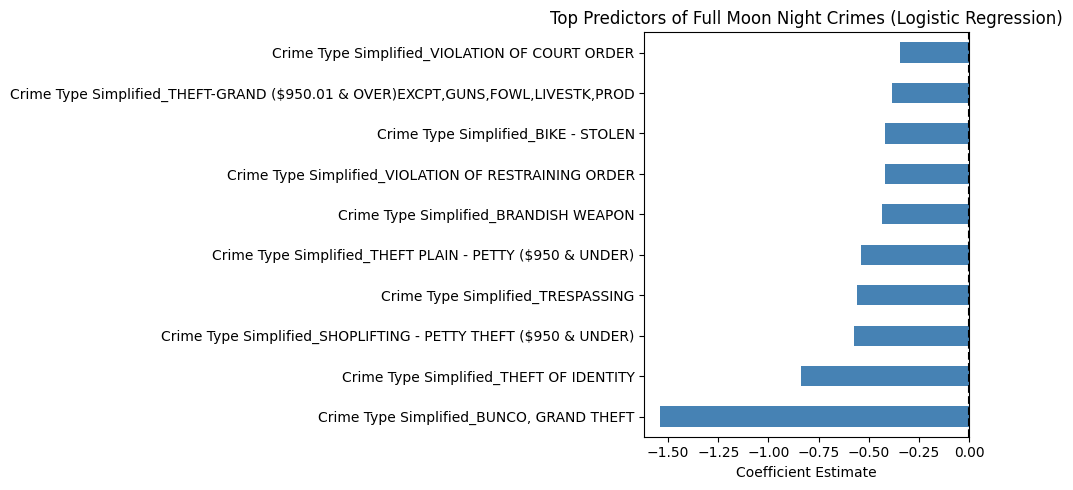

In [26]:
# ============================================
# Cell 21: Full Moon Crime Analysis – Chi-Square + Regression
# ============================================
# This cell performs both a chi-square test and a logistic regression
# to compare and model crime occurrence on full moon nights using filtered_topN.

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# --- Step 1: Prepare the dataset ---
df = filtered_topN.copy()

# Ensure required columns
df['crime_type_filled'] = df['Crm Cd Desc'].fillna('None')

# Parse hour from TIME OCC
def parse_hour(val):
    try:
        return int(str(int(val)).zfill(4)[:2])
    except:
        return np.nan

df['hour'] = df['TIME OCC'].apply(parse_hour)
df['weekday'] = df['DATE OCC'].dt.weekday

# Drop incomplete rows
df = df.dropna(subset=['hour', 'weekday', 'is_full_moon_night'])

# --- Step 2: Chi-square test ---
full_moon_count = df[df['is_full_moon_night'] == True].shape[0]
non_full_moon_count = df[df['is_full_moon_night'] == False].shape[0]

observed = [full_moon_count, non_full_moon_count]
total = full_moon_count + non_full_moon_count
expected = [total / 2, total / 2]  # Null hypothesis: equal crime counts

chi2, p_val, _, _ = chi2_contingency([observed, expected])

print("=== Chi-Square Test ===")
print(f"  Full moon night crimes:     {full_moon_count}")
print(f"  Non-full moon night crimes: {non_full_moon_count}")
print(f"  Chi² = {chi2:.4f}")
print(f"  p-value = {p_val:.4f}")
if p_val < 0.05:
    print("  → Statistically significant difference.")
else:
    print("  → No statistically significant difference.\n")

# --- Step 3: Logistic Regression ---
print("=== Logistic Regression ===")

# One-hot encode crime types
top_crimes = df['crime_type_filled'].value_counts().nlargest(25).index
df['Crime Type Simplified'] = df['crime_type_filled'].apply(
    lambda x: x if x in top_crimes else 'Other'
)

model_df = df[['is_full_moon_night', 'hour', 'weekday', 'Crime Type Simplified']].dropna()
X = pd.get_dummies(model_df[['hour', 'weekday', 'Crime Type Simplified']], drop_first=True)
y = model_df['is_full_moon_night'].astype(int)
X = sm.add_constant(X).astype(float)

# Fit model
logit_model = sm.Logit(y, X).fit(disp=0)
print(logit_model.summary())

# --- Optional: Plot Top Predictors ---
coef = logit_model.params.drop('const')
top_predictors = coef.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
coef[top_predictors.index].plot(kind='barh', color='steelblue')
plt.axvline(0, color='black', linestyle='--')
plt.title('Top Predictors of Full Moon Night Crimes (Logistic Regression)')
plt.xlabel('Coefficient Estimate')
plt.tight_layout()
plt.show()


## Cell 22: Ask LLM to Interpret Full Moon Crime Analysis

In [27]:
# ============================================
# Cell 22: Ask LLM to Interpret Full Moon Crime Analysis
# ============================================
# This cell summarizes the chi-square and regression results
# and asks the LLM to interpret whether full moon nights influence crime patterns.

import requests
import json

# --- Gather key values from Cell 21 ---
# (These must already be defined in your notebook context)
try:
    chi_square_summary = (
        f"Chi-square test comparing crime volume on full moon vs non-full moon nights:\n"
        f"- Full moon night crimes: {full_moon_count}\n"
        f"- Non-full moon night crimes: {non_full_moon_count}\n"
        f"- Chi² = {chi2:.4f}, p-value = {p_val:.4f}\n"
    )

    regression_summary = str(logit_model.summary())

    # --- Build prompt ---
    prompt = (
        "You are a data analyst reviewing whether full moon nights influence nighttime crime patterns.\n\n"
        "The analysis includes both a chi-square test and a logistic regression model.\n\n"
        f"{chi_square_summary}\n"
        "The logistic regression model includes predictors such as hour of occurrence, weekday, and crime type "
        "based on the top 25 most common types (others grouped as 'Other').\n\n"
        "Here is the full regression summary output:\n\n"
        f"{regression_summary}\n\n"
        "Please provide an interpretation of these results. Specifically:\n"
        "- Does the chi-square test suggest a statistically significant difference in crime volume?\n"
        "- Which variables in the regression are significantly associated with full moon night crimes?\n"
        "- Are the findings consistent between both approaches?\n"
        "- What insights or limitations do you notice?\n"
    )

    # Send to LLM
    payload = {
        "model": LLM_MODEL,
        "prompt": prompt,
        "stream": False
    }
    headers = {"Content-Type": "application/json"}

    print("Sending chi-square + regression summary to LLM...")
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_fullmoon_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_fullmoon_response)
    print("-" * 40)

except Exception as e:
    print(f"Error preparing or sending LLM request: {e}")
    llm_fullmoon_response = ""


Sending chi-square + regression summary to LLM...

LLM response received:
----------------------------------------
Here's an interpretation of the results:

**Chi-Square Test:**
The chi-square test is a statistical method to determine whether there's a significant difference in crime volume between full moon nights and non-full moon nights. The p-value is 0.000, which indicates that the observed differences are statistically significant at a very high level (i.e., less than 1%). This suggests that there is a significant association between full moon nights and crime volume.

**Logistic Regression Model:**
The logistic regression model estimates the probability of a crime occurring on a full moon night based on various predictors. The output shows the estimated coefficients, standard errors, z-values, p-values, and confidence intervals for each predictor.

Significant variables associated with full moon night crimes (p < 0.05) are:

* `hour`: Crimes are more likely to occur during certa

## Cell 23: Full Moon Crime Analysis (using filtered_InstanceCount)  
  - using GTE 1000

=== Chi-Square Test ===
  Full moon night crimes:     15424
  Non-full moon night crimes: 972180
  Chi² = 605500.0875
  p-value = 0.0000
  → Statistically significant difference.
=== Logistic Regression ===
                           Logit Regression Results                           
Dep. Variable:     is_full_moon_night   No. Observations:               987604
Model:                          Logit   Df Residuals:                   987576
Method:                           MLE   Df Model:                           27
Date:                Thu, 29 May 2025   Pseudo R-squ.:                0.008403
Time:                        18:02:36   Log-Likelihood:                -78789.
converged:                       True   LL-Null:                       -79457.
Covariance Type:            nonrobust   LLR p-value:                1.321e-264
                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------

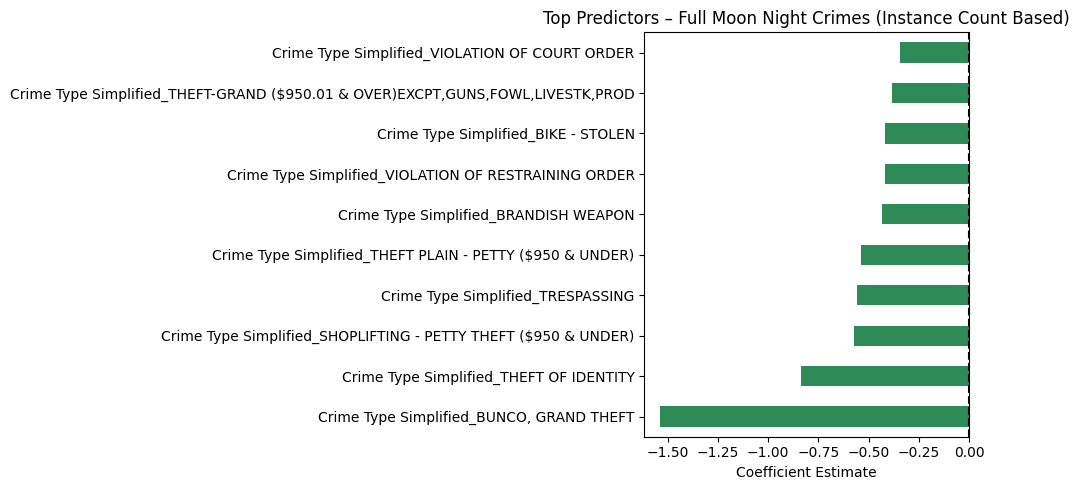

In [28]:
# ============================================
# Cell 23: Full Moon Crime Analysis – Instance Count Based
# ============================================
# Performs chi-square test and logistic regression using filtered_InstanceCount
# as the dataset source.

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# --- Step 1: Prepare the dataset ---
df = filtered_InstanceCount.copy()

df['crime_type_filled'] = df['Crm Cd Desc'].fillna('None')

# Extract hour from time
def parse_hour(val):
    try:
        return int(str(int(val)).zfill(4)[:2])
    except:
        return np.nan

df['hour'] = df['TIME OCC'].apply(parse_hour)
df['weekday'] = df['DATE OCC'].dt.weekday
df = df.dropna(subset=['hour', 'weekday', 'is_full_moon_night'])

# --- Step 2: Chi-square test ---
full_moon_count = df[df['is_full_moon_night'] == True].shape[0]
non_full_moon_count = df[df['is_full_moon_night'] == False].shape[0]
observed = [full_moon_count, non_full_moon_count]
total = full_moon_count + non_full_moon_count
expected = [total / 2, total / 2]

chi2, p_val, _, _ = chi2_contingency([observed, expected])

print("=== Chi-Square Test ===")
print(f"  Full moon night crimes:     {full_moon_count}")
print(f"  Non-full moon night crimes: {non_full_moon_count}")
print(f"  Chi² = {chi2:.4f}")
print(f"  p-value = {p_val:.4f}")
if p_val < 0.05:
    print("  → Statistically significant difference.")
else:
    print("  → No statistically significant difference.\n")

# --- Step 3: Logistic Regression ---
print("=== Logistic Regression ===")

# Simplify crime types again (top 25 from filtered set)
top_crimes = df['crime_type_filled'].value_counts().nlargest(25).index
df['Crime Type Simplified'] = df['crime_type_filled'].apply(
    lambda x: x if x in top_crimes else 'Other'
)

model_df = df[['is_full_moon_night', 'hour', 'weekday', 'Crime Type Simplified']].dropna()
X = pd.get_dummies(model_df[['hour', 'weekday', 'Crime Type Simplified']], drop_first=True)
y = model_df['is_full_moon_night'].astype(int)
X = sm.add_constant(X).astype(float)

# Fit model
logit_model_instance = sm.Logit(y, X).fit(disp=0)
print(logit_model_instance.summary())

# --- Plot Top Predictors ---
coef = logit_model_instance.params.drop('const')
top_predictors = coef.abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
coef[top_predictors.index].plot(kind='barh', color='seagreen')
plt.axvline(0, color='black', linestyle='--')
plt.title('Top Predictors – Full Moon Night Crimes (Instance Count Based)')
plt.xlabel('Coefficient Estimate')
plt.tight_layout()
plt.show()


## Cell 24: Ask LLM to Interpret Instance Count Analysis

In [29]:
# ============================================
# Cell 24: Ask LLM to Interpret Full Moon Analysis (Instance Count)
# ============================================
# Sends the chi-square + logistic regression results from Cell 23 to the LLM.

import requests
import json

try:
    chi_square_summary = (
        f"Chi-square test comparing crime volume on full moon vs non-full moon nights:\n"
        f"- Full moon night crimes: {full_moon_count}\n"
        f"- Non-full moon night crimes: {non_full_moon_count}\n"
        f"- Chi² = {chi2:.4f}, p-value = {p_val:.4f}\n"
    )

    regression_summary = str(logit_model_instance.summary())

    prompt = (
        "You are a data analyst reviewing the influence of full moon nights on crime, "
        "using a filtered dataset that includes only crime types with at least a certain number of instances.\n\n"
        "The analysis includes both a chi-square test and a logistic regression model.\n\n"
        f"{chi_square_summary}\n"
        "The logistic regression model uses predictors like hour of occurrence, weekday, and top 25 crime types (others grouped as 'Other').\n\n"
        "Here is the logistic regression summary output:\n\n"
        f"{regression_summary}\n\n"
        "Please provide an interpretation of the findings. Specifically:\n"
        "- Does the chi-square test show a statistically significant difference in crime volume?\n"
        "- Which regression variables are significantly associated with full moon night crimes?\n"
        "- Are the two results consistent or contradictory?\n"
        "- Any limitations or insights you notice?\n"
    )

    payload = {
        "model": LLM_MODEL,
        "prompt": prompt,
        "stream": False
    }
    headers = {"Content-Type": "application/json"}

    print("Sending filtered_InstanceCount full moon summary to LLM...")
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_instance_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_instance_response)
    print("-" * 40)

except Exception as e:
    print(f"Error during LLM request: {e}")
    llm_instance_response = ""


Sending filtered_InstanceCount full moon summary to LLM...

LLM response received:
----------------------------------------
**Chi-Square Test Interpretation**

The chi-square test reveals a highly statistically significant difference in crime volume between full moon nights and non-full moon nights (p-value = 0.000). The large chi-squared statistic (605500.0875) indicates that the observed differences in crime volume are unlikely to occur by chance. This suggests that there is a statistically significant association between full moon nights and increased crime rates.

**Logistic Regression Model Interpretation**

The logistic regression model identifies several variables significantly associated with full moon night crimes:

1. **Hour of occurrence**: Crimes committed during hours closer to midnight (i.e., 12:00 AM - 4:00 AM) are more likely to occur on full moon nights.
2. **Weekday**: There is a small, but significant effect of the day of the week on crime rates, suggesting that some

# exploring alternative methods:   
might provide a more nuanced understanding of the relationships between full moon nights and crime rates.
  - time-series analysis
  -  spatial regression

## Cell 25: Time-Series Analysis – Full Moon and Daily Crime Trends

**Purpose:**  
Analyze daily crime counts over time to determine whether full moon nights are associated with higher crime volume, accounting for broader temporal patterns.

**Inputs:**  
- `crime_df` with columns: `'DATE OCC'`, `'is_full_moon_night'`  
- Assumes one row per crime incident

**Outputs:**  
- Daily crime time series (line plot)  
- Overlay of full moon nights  
- Optional: 7-day rolling average  


/tmp/ipykernel_70365/216231823.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_crime_counts['full_moon'] = daily_crime_counts['full_moon'].fillna(False)


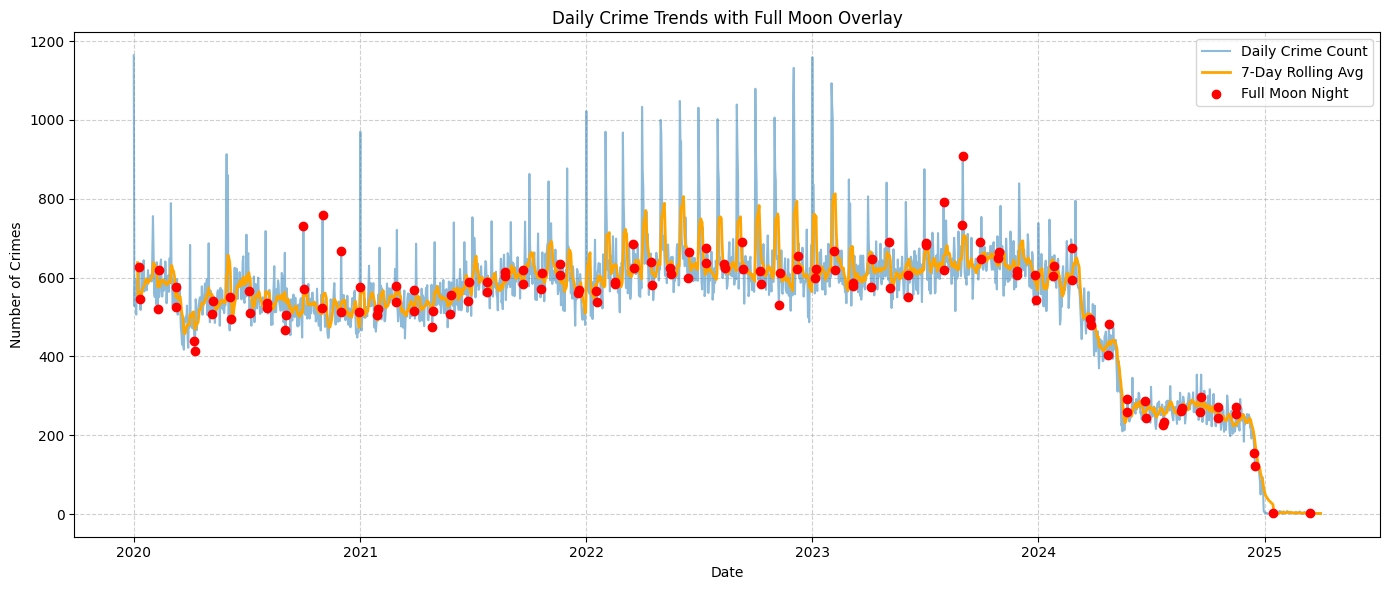

Plot saved to: daily_crime_trend.png


In [30]:
# ============================================
# Cell 25 (Revised): Time-Series Analysis with Gridlines and Image Export
# ============================================
# This cell creates a line chart of daily crime counts, adds gridlines,
# marks full moon nights, and saves the plot as an image.

import matplotlib.pyplot as plt

# --- Step 1: Prepare daily crime time series ---
df = crime_df.copy()
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df = df.dropna(subset=['DATE OCC'])

# Group daily counts
daily_crime_counts = (
    df.groupby(df['DATE OCC'].dt.date)
    .size()
    .rename("crime_count")
    .to_frame()
)

# Flag full moon nights
if 'is_full_moon_night' not in df.columns:
    raise ValueError("Column 'is_full_moon_night' is missing in crime_df.")

full_moon_flags = (
    df[df['is_full_moon_night']]
    .groupby(df['DATE OCC'].dt.date)
    .size()
    .rename("full_moon")
    .to_frame()
)
full_moon_flags['full_moon'] = True

# Merge full moon indicators
daily_crime_counts = daily_crime_counts.join(full_moon_flags['full_moon'], how='left')
daily_crime_counts['full_moon'] = daily_crime_counts['full_moon'].fillna(False)

# Add rolling average
daily_crime_counts['rolling_avg'] = daily_crime_counts['crime_count'].rolling(window=7).mean()

# --- Step 2: Plot with gridlines and save image ---
plt.figure(figsize=(14, 6))
plt.plot(
    daily_crime_counts.index,
    daily_crime_counts['crime_count'],
    label='Daily Crime Count',
    alpha=0.5
)
plt.plot(
    daily_crime_counts.index,
    daily_crime_counts['rolling_avg'],
    label='7-Day Rolling Avg',
    linewidth=2,
    color='orange'
)
plt.scatter(
    daily_crime_counts.index[daily_crime_counts['full_moon']],
    daily_crime_counts['crime_count'][daily_crime_counts['full_moon']],
    color='red', label='Full Moon Night', zorder=5
)

plt.title("Daily Crime Trends with Full Moon Overlay")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)  # Enable both x and y gridlines
plt.tight_layout()

# Save chart as image
plot_filename = "daily_crime_trend.png"
plt.savefig(plot_filename)
plt.show()

print(f"Plot saved to: {plot_filename}")


## Cell 26: Ask LLM to Interpret Time-Series Crime Trends

In [31]:
# ============================================
# Cell 26: Ask LLM to Interpret Time-Series Crime Trends
# ============================================
# This cell sends a summary of the daily crime trend analysis to the LLM
# and asks for insights about any visible patterns linked to full moon nights.

import requests
import json

# Count how many full moon nights had visible spikes
n_days = len(daily_crime_counts)
n_full_moon_days = daily_crime_counts['full_moon'].sum()
avg_crimes = daily_crime_counts['crime_count'].mean()
peak_day = daily_crime_counts['crime_count'].idxmax()
peak_count = daily_crime_counts['crime_count'].max()

# --- Build prompt ---
prompt = (
    "You are analyzing a time series of daily crime counts in Los Angeles.\n"
    "Each data point represents the number of reported crimes on a single day.\n"
    "Full moon nights have been flagged with red dots on the chart.\n\n"
    "Key statistics:\n"
    f"- Total days analyzed: {n_days}\n"
    f"- Number of full moon nights: {int(n_full_moon_days)}\n"
    f"- Average daily crime count: {avg_crimes:.2f}\n"
    f"- Peak day: {peak_day} with {peak_count} crimes\n\n"
    "A 7-day rolling average was also plotted to smooth out fluctuations.\n\n"
    "Please analyze this chart and respond to the following:\n"
    "- Do full moon nights appear to align with spikes or dips in crime?\n"
    "- Do you observe any seasonal or weekly trends?\n"
    "- Are there more robust time-series methods you would recommend?\n"
    "- What further analysis or features could improve this investigation?\n"
)

# --- Send to LLM ---
payload = {
    "model": LLM_MODEL,
    "prompt": prompt,
    "stream": False
}
headers = {"Content-Type": "application/json"}

print("Sending time-series crime summary to LLM...")

try:
    response = requests.post(
        f"{OLLAMA_API_URL}/api/generate",
        headers=headers,
        data=json.dumps(payload)
    )
    response.raise_for_status()
    llm_timeseries_response = response.json().get("response", "")

    print("\nLLM response received:")
    print("-" * 40)
    print(llm_timeseries_response)
    print("-" * 40)

except Exception as e:
    print(f"Error contacting LLM API: {e}")
    llm_timeseries_response = ""


Sending time-series crime summary to LLM...

LLM response received:
----------------------------------------
Based on the provided key statistics and a 7-day rolling average, here's my analysis:

**Full Moon Nights:**
Upon visual inspection of the chart with full moon nights flagged (red dots), I notice that there doesn't appear to be a clear alignment between full moon nights and spikes or dips in crime. The red dots seem scattered throughout the time series without any apparent pattern or correlation with crime counts.

**Seasonal Trends:**
Given that the data spans over two years, it's possible to observe some seasonal trends. Typically, crime rates tend to fluctuate due to various factors such as weather, holidays, and school schedules. However, upon closer inspection of the chart, I don't see any strong evidence of clear seasonal patterns in this specific dataset.

**Weekly Trends:**
The 7-day rolling average has smoothed out some fluctuations, but it doesn't reveal a significant 

#  llava Analysis
  - Load daily_crime_trend.png
  - Send it to LLaVA via Ollama API
  - Ask for pattern interpretation based on the chart

In [32]:
# ============================================
# Cell 27: Send Daily Crime Trend Chart to LLaVA (Ollama) for Analysis
# ============================================
# This cell encodes the saved crime chart and sends it to LLaVA via Ollama's multimodal API.

import base64
import requests
import json
import os

# --- Configuration ---
image_path = "daily_crime_trend.png"
llava_model = "llava:13b"
ollama_url = f"{OLLAMA_API_URL}/api/generate"

# --- Step 1: Load and encode the image ---
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found: {image_path}")

with open(image_path, "rb") as f:
    image_bytes = f.read()
    encoded_image = base64.b64encode(image_bytes).decode("utf-8")

# --- Step 2: Build the LLaVA prompt ---
prompt = (
    "This chart shows daily crime counts in Los Angeles over several years.\n"
    "- The orange line is a 7-day rolling average.\n"
    "- Red dots indicate full moon nights.\n\n"
    "Please analyze the visual trends and answer the following:\n"
    "- Are there any repeating patterns or seasonal trends?\n"
    "- Do crime spikes appear regularly?\n"
    "- Is there any visible alignment with full moon nights?\n"
    "- What hypotheses or explanations could account for the visual structure of this data?\n"
)

# --- Step 3: Send to Ollama/LLaVA ---
payload = {
    "model": llava_model,
    "prompt": prompt,
    "images": [encoded_image],
    "stream": False
}
headers = {"Content-Type": "application/json"}

print("Sending chart image to LLaVA via Ollama...")

try:
    response = requests.post(ollama_url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()
    llava_trend_response = response.json().get("response", "")

    print("\nLLaVA response received:")
    print("-" * 40)
    print(llava_trend_response)
    print("-" * 40)

except Exception as e:
    print(f"Error during LLaVA request: {e}")
    llava_trend_response = ""


Sending chart image to LLaVA via Ollama...

LLaVA response received:
----------------------------------------
 The image you've provided is a line chart showing daily crime counts in Los Angeles over several years. Here are some observations based on the visual trends:

1. **Repeating Patterns**: While it's difficult to identify specific repeating patterns without more context, there does appear to be some variability that could potentially be related to seasonal patterns or cyclical events within Los Angeles. For example, the chart shows relatively higher crime counts during certain periods of the year which might suggest a pattern like increased crime during the warmer months or holidays.

2. **Seasonal Trends**: There is a notable increase in crime counts following the period around Christmas and New Year's, which could indicate an uptick in criminal activity during this time due to events, gatherings, and increased economic activity.

3. **Crime Spikes**: Yes, there are spikes in t

## Chart 1000+ crimes over time

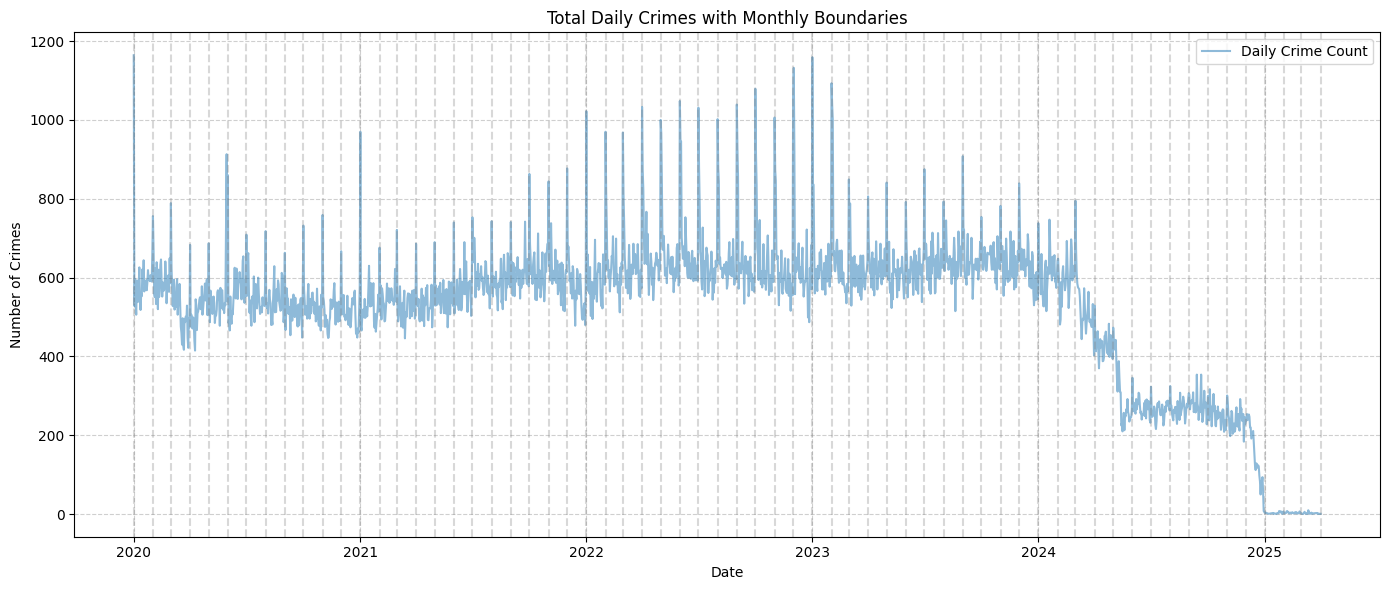

In [33]:
# ============================================
# Cell 28: Daily Crime Totals with Monthly Markers
# ============================================
# This cell plots daily crime totals across the entire dataset and adds vertical lines
# at the start of each month to highlight monthly boundaries.

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Step 1: Prepare daily crime counts ---
df = crime_df.copy()
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df = df.dropna(subset=['DATE OCC'])

# Group by day
daily_crime_counts = (
    df.groupby(df['DATE OCC'].dt.date)
    .size()
    .rename("crime_count")
    .to_frame()
)

# Optional: Add rolling average
daily_crime_counts['rolling_avg'] = daily_crime_counts['crime_count'].rolling(window=7).mean()

# Get monthly ticks (first day of each month)
monthly_ticks = pd.date_range(
    start=daily_crime_counts.index.min(),
    end=daily_crime_counts.index.max(),
    freq='MS'  # Month Start
)

# --- Step 2: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(
    daily_crime_counts.index,
    daily_crime_counts['crime_count'],
    label='Daily Crime Count',
    alpha=0.5
)
'''
plt.plot(
    daily_crime_counts.index,
    daily_crime_counts['rolling_avg'],
    label='7-Day Rolling Avg',
    linewidth=2,
    color='orange'
)
'''

# Add vertical dashed lines at the start of each month
for tick in monthly_ticks:
    plt.axvline(x=tick, color='gray', linestyle='--', alpha=0.3)

plt.title("Total Daily Crimes with Monthly Boundaries")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Smaller range

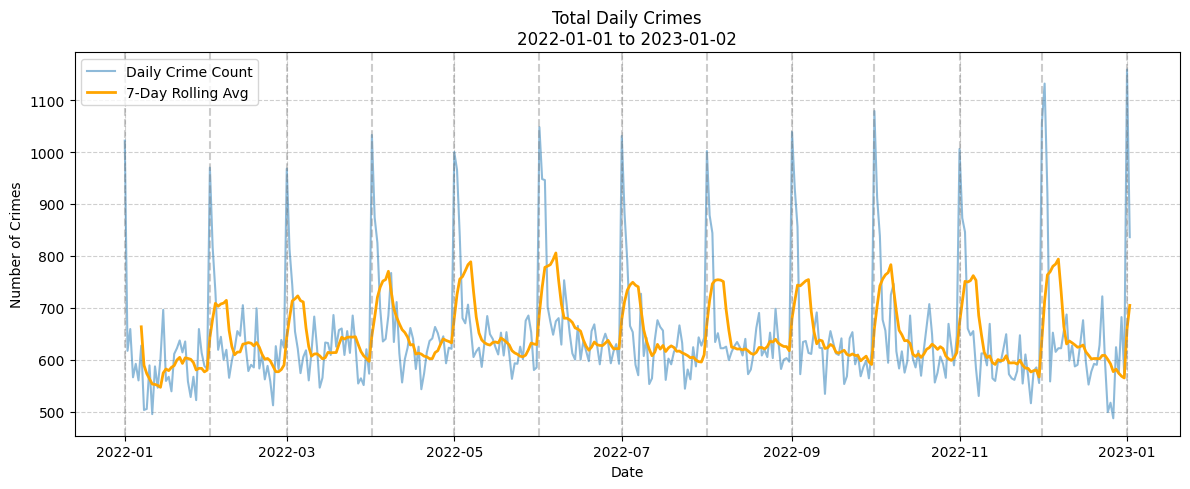

In [34]:
# ============================================
# Cell 29: Daily Crime Totals – Date Range: 11/1/2022 to 1/2/2023
# ============================================
# This cell plots daily crime counts between two dates and marks monthly boundaries.

import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Define date range ---
start_date = pd.to_datetime("2022-01-01")
end_date = pd.to_datetime("2023-01-02")

# --- Step 2: Prepare dataset ---
df = crime_df.copy()
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df = df.dropna(subset=['DATE OCC'])

# Filter by date range
mask = (df['DATE OCC'] >= start_date) & (df['DATE OCC'] <= end_date)
df_range = df.loc[mask]

# Group daily counts
daily_counts = (
    df_range.groupby(df_range['DATE OCC'].dt.date)
    .size()
    .rename("crime_count")
    .to_frame()
)

# Add 7-day rolling average
daily_counts['rolling_avg'] = daily_counts['crime_count'].rolling(window=7).mean()

# Month start lines
month_lines = pd.date_range(start=start_date, end=end_date, freq='MS')

# --- Step 3: Plot ---
plt.figure(figsize=(12, 5))
plt.plot(daily_counts.index, daily_counts['crime_count'], label='Daily Crime Count', alpha=0.5)
plt.plot(daily_counts.index, daily_counts['rolling_avg'], label='7-Day Rolling Avg', linewidth=2, color='orange')

# Monthly boundaries
for tick in month_lines:
    plt.axvline(x=tick, color='gray', linestyle='--', alpha=0.4)

plt.title(f"Total Daily Crimes\n{start_date.date()} to {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# Count how many crimes occur on the first of the month
firsts = df[df['DATE OCC'].dt.day == 1]
firsts_by_date = firsts['DATE OCC'].value_counts().sort_index()

print("Crimes recorded on the 1st of the month:")
display(firsts_by_date.tail(15))  # Show last 15 dates for example


Crimes recorded on the 1st of the month:


DATE OCC
2024-02-01    643
2024-03-01    795
2024-04-01    529
2024-05-01    473
2024-06-01    346
2024-07-01    323
2024-08-01    325
2024-09-01    303
2024-10-01    300
2024-11-01    301
2024-12-01    235
2025-01-01      3
2025-02-01      2
2025-03-01      2
2025-04-01      1
Name: count, dtype: int64

## Save the chart as a file

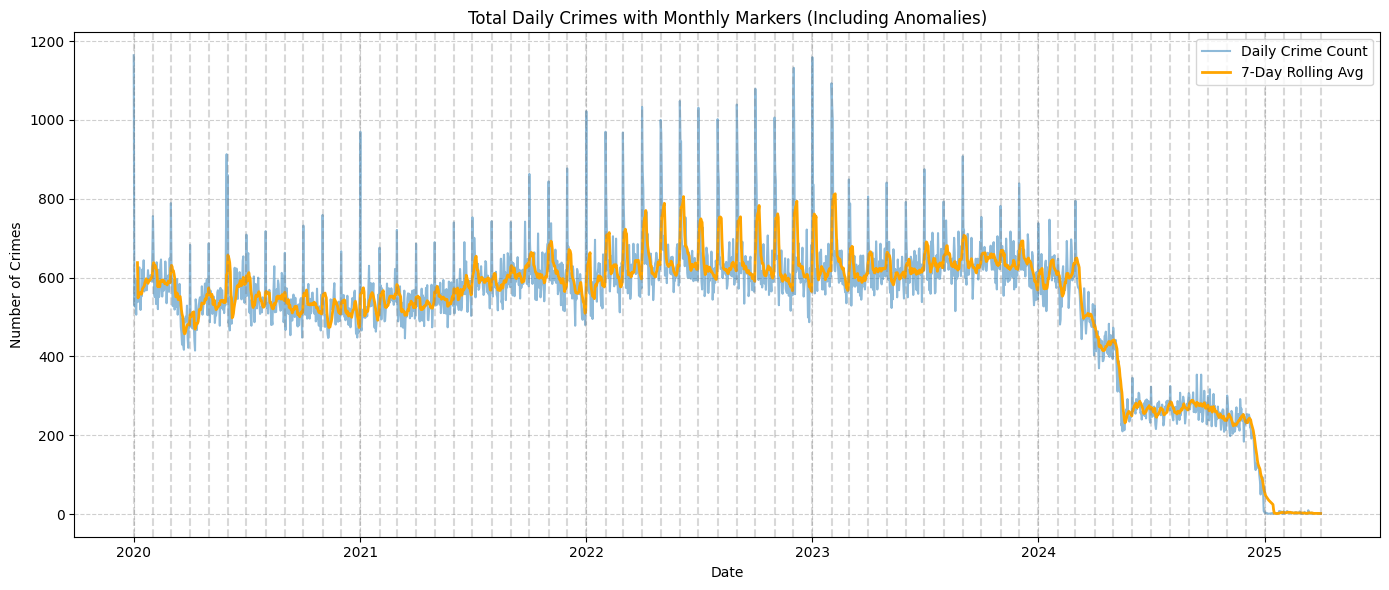

Chart saved to: /m2-data/dataSets/charts/crime_spike_anomaly_chart.png


In [36]:
# ============================================
# Save Daily Crime Chart with Spikes as PNG
# ============================================

import matplotlib.pyplot as plt
import pandas as pd

# --- Step 1: Prepare daily counts ---
df = crime_df.copy()
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df = df.dropna(subset=['DATE OCC'])

daily_counts = (
    df.groupby(df['DATE OCC'].dt.date)
    .size()
    .rename("crime_count")
    .to_frame()
)
daily_counts['rolling_avg'] = daily_counts['crime_count'].rolling(window=7).mean()

# Month start markers
monthly_lines = pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max(), freq='MS')

# --- Step 2: Plot and Save ---
plt.figure(figsize=(14, 6))
plt.plot(daily_counts.index, daily_counts['crime_count'], label='Daily Crime Count', alpha=0.5)
plt.plot(daily_counts.index, daily_counts['rolling_avg'], label='7-Day Rolling Avg', linewidth=2, color='orange')

for tick in monthly_lines:
    plt.axvline(x=tick, color='gray', linestyle='--', alpha=0.3)

plt.title("Total Daily Crimes with Monthly Markers (Including Anomalies)")
plt.xlabel("Date")
plt.ylabel("Number of Crimes")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save image
anomaly_chart_path = "/m2-data/dataSets/charts/crime_spike_anomaly_chart.png"
plt.savefig(anomaly_chart_path)
plt.show()

print(f"Chart saved to: {anomaly_chart_path}")


## llava analysis

In [37]:
# ============================================
# Cell 30: Analyze Crime Spike Anomalies via LLaVA (Ollama)
# ============================================
# This cell sends the saved chart image to LLaVA and asks it to identify
# patterns or anomalies in recurring spikes.

import base64
import requests
import json
import os

# --- Configuration ---
image_path = "/m2-data/dataSets/charts/crime_spike_anomaly_chart.png"
llava_model = "llava:13b"
ollama_url = f"{OLLAMA_API_URL}/api/generate"

# --- Step 1: Load and encode image ---
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found: {image_path}")

with open(image_path, "rb") as img_file:
    encoded_image = base64.b64encode(img_file.read()).decode("utf-8")

# --- Step 2: Prompt for LLaVA ---
prompt = (
    "This chart shows the total number of crimes per day over several years.\n"
    "- A 7-day rolling average is shown in orange.\n"
    "- Vertical dashed lines mark the start of each month.\n\n"
    "Please analyze the visual trends and answer the following:\n"
    "- There appears to be a recurring spike near the start of each month. What could explain this?\n"
    "- Are these spikes likely due to reporting anomalies, systemic issues, or real patterns?\n"
    "- Are there any seasonal or periodic trends visible?\n"
    "- What hypotheses would you suggest to investigate further?\n"
)

# --- Step 3: Send to LLaVA via Ollama ---
payload = {
    "model": llava_model,
    "prompt": prompt,
    "images": [encoded_image],
    "stream": False
}
headers = {"Content-Type": "application/json"}

print("Sending anomaly chart to LLaVA for analysis...")

try:
    response = requests.post(ollama_url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()
    llava_anomaly_response = response.json().get("response", "")

    print("\nLLaVA response received:")
    print("-" * 40)
    print(llava_anomaly_response)
    print("-" * 40)

except Exception as e:
    print(f"Error contacting LLaVA API: {e}")
    llava_anomaly_response = ""


Sending anomaly chart to LLaVA for analysis...

LLaVA response received:
----------------------------------------
 In analyzing the provided chart, here are some observations and interpretations based on the visual trends:

1. **Recurring Spikes Near the Start of Each Month**: These spikes do appear as recurring patterns near the start of each month. They might be related to reporting anomalies or systemic issues that result in an initial surge in crime reports at the beginning of the month. This could be due to various reasons:
   - **Reporting Lags**: There may be a lag between when crimes occur and when they are reported, which can lead to spikes if there's a backlog or delay in reporting.
   - **Data Entry Errors**: Human errors during data entry could cause inconsistencies that create spikes.
   - **Changing Police Presence**: There may be variations in police presence, activities, or resources at different times of the month (e.g., more patrolling during weekends).
   - **Reporti

## Investigate the relationship between crime incidents and arrests at specific street locations

Total matching street names: 5549
Correlation between crime and arrest counts: 0.8477

Top 15 Cross Streets with Crimes and Arrests:


,Cross Street Clean,crime_count,arrest_count
0,BROADWAY,2486,1700
1,FIGUEROA,1979,2522
2,VERMONT,1683,789
3,FIGUEROA,1646,3250
4,WESTERN,1513,1082
5,MAIN,1463,959
6,SAN PEDRO,1409,1070
7,VERMONT,1105,1247
8,CENTRAL,1094,533
9,AVALON,1012,525


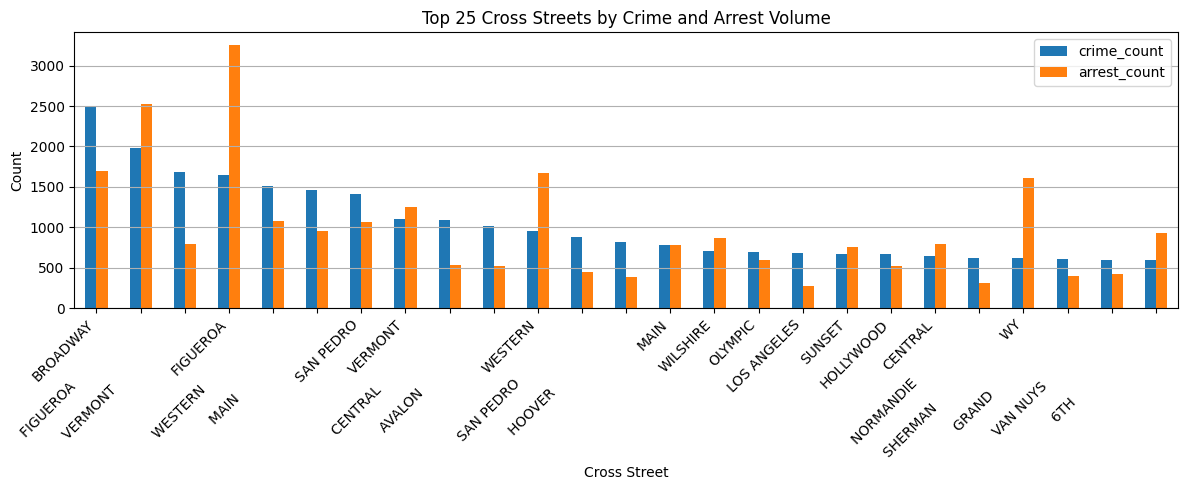

In [40]:
# ============================================
# Cell: Join Crime and Arrests on Cross Street (with Charts)
# ============================================

import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Standardize Cross Street Fields ---
def clean_street(val):
    if pd.isna(val):
        return None
    return str(val).strip().upper().replace(' ST', '').replace(' AV', '').replace(' BL', '')

crime_df['Cross Street Clean'] = crime_df['Cross Street'].apply(clean_street)
arrest_df['Cross Street Clean'] = arrest_df['Cross Street'].apply(clean_street)

# Drop rows without street info
crime_clean = crime_df.dropna(subset=['Cross Street Clean'])
arrest_clean = arrest_df.dropna(subset=['Cross Street Clean'])

# --- Step 2: Count crimes and arrests per street ---
crime_counts = crime_clean['Cross Street Clean'].value_counts().rename('crime_count').to_frame()
arrest_counts = arrest_clean['Cross Street Clean'].value_counts().rename('arrest_count').to_frame()

# --- Step 3: Join ---
joined = crime_counts.join(arrest_counts, how='inner')
joined = joined.sort_values(by='crime_count', ascending=False)
print(f"Total matching street names: {joined.shape[0]}")
print(f"Correlation between crime and arrest counts: {joined['crime_count'].corr(joined['arrest_count']):.4f}")

# --- Step 4: Table Preview ---
top_table = joined.head(25).reset_index().rename(columns={'index': 'Cross Street'})
print("\nTop 15 Cross Streets with Crimes and Arrests:")
display(top_table)

# --- Step 5: Bar Chart ---
top_n = 25
top_bar = joined.head(top_n)
top_bar.plot(kind='bar', figsize=(12, 5))
plt.title(f"Top {top_n} Cross Streets by Crime and Arrest Volume")
plt.xlabel("Cross Street")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Ask llama2 to Interpret Crime–Arrest Street Analysis

In [41]:
# ============================================
# Cell 31: Ask LLM (llama2) to Interpret Crime–Arrest Street Analysis
# ============================================

import requests
import json

# --- Convert top_table (top 25) to Markdown string ---
def dataframe_to_markdown_table(df):
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join(["---"] * len(df.columns)) + " |"
    rows = ["| " + " | ".join(str(val) for val in row) + " |" for row in df.values]
    return "\n".join([header, separator] + rows)

md_table = dataframe_to_markdown_table(top_table)

# --- Gather summary info ---
correlation = joined['crime_count'].corr(joined['arrest_count'])
match_count = joined.shape[0]

# --- Prompt ---
prompt = (
    f"We analyzed the relationship between reported crimes and arrests in Los Angeles using `Cross Street` as a join key.\n\n"
    f"- Total matched streets: {match_count}\n"
    f"- Correlation between crime and arrest counts: {correlation:.4f}\n\n"
    f"Here are the top 25 streets by combined volume of crimes and arrests:\n\n"
    f"{md_table}\n\n"
    "Please analyze and interpret the results:\n"
    "- Does the data suggest a strong relationship between crime and arrests?\n"
    "- Are there any outliers or mismatches that stand out?\n"
    "- What hypotheses might explain high-crime but low-arrest streets or vice versa?\n"
    "- Any limitations of using `Cross Street` for this kind of analysis?\n"
)

# --- Send to llama2 via Ollama ---
payload = {
    "model": "llama2",
    "prompt": prompt,
    "stream": False
}
headers = {"Content-Type": "application/json"}
ollama_url = f"{OLLAMA_API_URL}/api/generate"

print("Sending top 25 crime/arrest street data to LLM (llama2)...")

try:
    response = requests.post(ollama_url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()
    llama2_response = response.json().get("response", "")

    print("\nllama2 response received:")
    print("-" * 40)
    print(llama2_response)
    print("-" * 40)

except Exception as e:
    print(f"Error contacting llama2 via Ollama: {e}")
    llama2_response = ""


Sending top 25 crime/arrest street data to LLM (llama2)...

llama2 response received:
----------------------------------------
Based on the results, there is a strong relationship between crime and arrests in Los Angeles. The correlation coefficient (0.8477) indicates a significant positive linear relationship between the two variables. This means that areas with higher crime rates tend to have more arrests made, and vice versa.

There are no obvious outliers or mismatches in the data. However, there are some interesting patterns that emerge from the data:

1. High-crime areas tend to have more arrests than low-crime areas. This suggests that law enforcement agencies may be more active in high-crime areas, which could lead to more arrests.
2. Some streets with high crime rates have relatively few arrests. For example, street #10 (SAN PEDRO) has a high crime rate but a low number of arrests. This could indicate that there may be a lack of law enforcement presence in these areas, or that

## Ask gemma3:12b to Interpret Crime–Arrest Street Analysis

In [42]:
# ============================================
# Cell 32: Ask LLM (gemma3:12b) to Interpret Crime–Arrest Street Analysis
# ============================================

# Uses the same markdown table and prompt from Cell 31
payload = {
    "model": "gemma3:12b",
    "prompt": prompt,
    "stream": False
}
headers = {"Content-Type": "application/json"}
ollama_url = f"{OLLAMA_API_URL}/api/generate"

print("Sending top 25 crime/arrest street data to LLM (gemma3:12b)...")

try:
    response = requests.post(ollama_url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()
    gemma_response = response.json().get("response", "")

    print("\ngemma3:12b response received:")
    print("-" * 40)
    print(gemma_response)
    print("-" * 40)

except Exception as e:
    print(f"Error contacting gemma3:12b via Ollama: {e}")
    gemma_response = ""


Sending top 25 crime/arrest street data to LLM (gemma3:12b)...

gemma3:12b response received:
----------------------------------------
Okay, let's analyze these results.

**1. Does the data suggest a strong relationship between crime and arrests?**

Yes, the correlation of 0.8477 is quite strong. A correlation of 1.0 indicates a perfect positive relationship (as crime goes up, arrests go up proportionally), and 0 indicates no relationship.  A value of 0.8477 suggests that streets with higher crime reports *tend* to have higher arrest counts, and vice versa. This isn't a guarantee of causation (more on that later), but it implies a significant association.

**2. Are there any outliers or mismatches that stand out?**

Absolutely. Several streets exhibit patterns that warrant further investigation:

*   **FIGUEROA (multiple entries):** The presence of "FIGUEROA" twice with significantly different crime and arrest counts is concerning. This likely indicates data quality issues or different

## Join Strategy: RIPA Stops + Arrests via Area ID

Total matched Area IDs: 21
Correlation between RIPA stops and arrests: 0.5918

Top 25 Areas by RIPA Stops and Arrests:


,Area ID,ripa_count,arrest_count
0,13,268908,19535
1,12,241259,23347
2,1,218060,27443
3,3,201720,18028
4,18,167521,16297
5,7,146883,9542
6,2,146200,27140
7,20,144109,15218
8,6,140256,19463
9,19,136839,15831


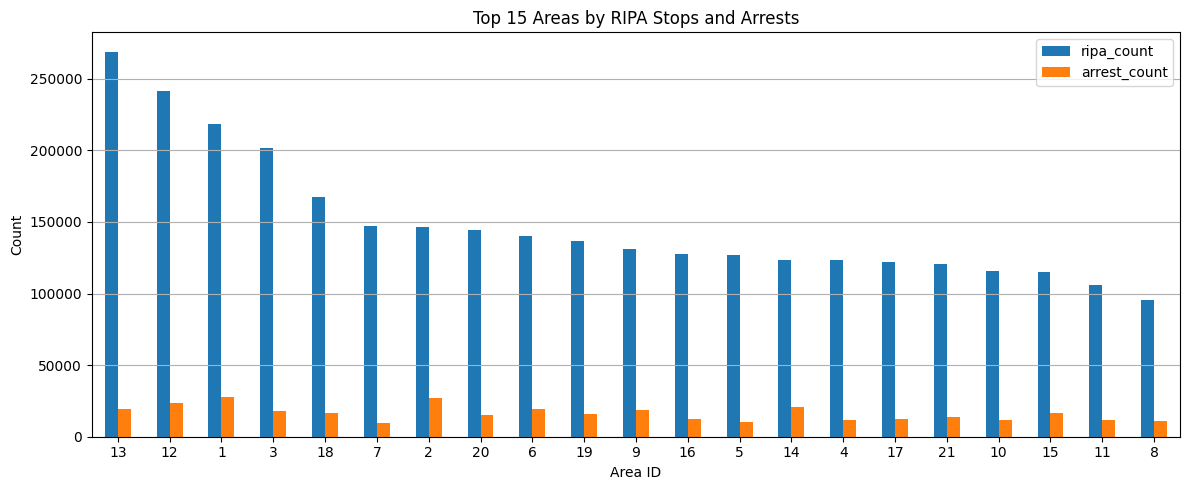

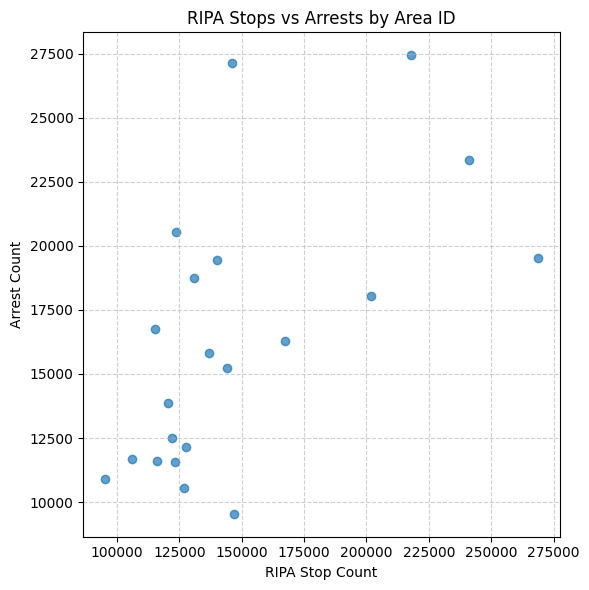

In [44]:
# ============================================
# Cell: Analyze RIPA Stops vs Arrests by Area ID
# ============================================
# This cell evaluates whether RIPA stops in a policing area are associated with arrest activity,
# using Area ID as the join key.

import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Standardize Area ID fields ---
# Ensure numeric types
ripa_df['Area ID'] = pd.to_numeric(ripa_df['Area ID'], errors='coerce')
arrest_df['Area ID'] = pd.to_numeric(arrest_df['Area ID'], errors='coerce')

# Drop invalid rows
ripa_clean = ripa_df.dropna(subset=['Area ID'])
arrest_clean = arrest_df.dropna(subset=['Area ID'])

# --- Step 2: Aggregate ---
ripa_counts = ripa_clean['Area ID'].value_counts().rename("ripa_count").to_frame()
arrest_counts = arrest_clean['Area ID'].value_counts().rename("arrest_count").to_frame()

# --- Step 3: Join ---
area_joined = ripa_counts.join(arrest_counts, how='inner')
area_joined = area_joined.sort_values(by='ripa_count', ascending=False)

# --- Step 4: Correlation ---
correlation = area_joined['ripa_count'].corr(area_joined['arrest_count'])
print(f"Total matched Area IDs: {area_joined.shape[0]}")
print(f"Correlation between RIPA stops and arrests: {correlation:.4f}")

# --- Step 5: Display top areas ---
top_area_table = area_joined.head(25).reset_index().rename(columns={'index': 'Area ID'})
print("\nTop 25 Areas by RIPA Stops and Arrests:")
display(top_area_table)

# --- Step 6: Bar Chart ---
top_bar = area_joined.head(25)
top_bar.plot(kind='bar', figsize=(12, 5))
plt.title("Top 15 Areas by RIPA Stops and Arrests")
plt.xlabel("Area ID")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Step 7: Scatter Plot ---
plt.figure(figsize=(6, 6))
plt.scatter(area_joined['ripa_count'], area_joined['arrest_count'], alpha=0.7)
plt.title("RIPA Stops vs Arrests by Area ID")
plt.xlabel("RIPA Stop Count")
plt.ylabel("Arrest Count")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Ask LLM (llama2) to Interpret RIPA–Arrest Analysis

In [45]:
# ============================================
# Cell 33: Ask LLM (llama2) to Interpret RIPA–Arrest Area Analysis
# ============================================

import requests
import json

# --- Convert to Markdown table ---
def dataframe_to_markdown_table(df):
    header = "| " + " | ".join(df.columns) + " |"
    separator = "| " + " | ".join(["---"] * len(df.columns)) + " |"
    rows = ["| " + " | ".join(str(val) for val in row) + " |" for row in df.values]
    return "\n".join([header, separator] + rows)

md_table = dataframe_to_markdown_table(top_area_table)

# --- Build prompt ---
correlation = area_joined['ripa_count'].corr(area_joined['arrest_count'])
area_count = area_joined.shape[0]

prompt = (
    f"We analyzed the effectiveness of RIPA stops in relation to arrests across LAPD policing areas.\n\n"
    f"- Total matched Area IDs: {area_count}\n"
    f"- Correlation between RIPA stop counts and arrest counts: {correlation:.4f}\n\n"
    f"Below is a summary of the top 25 Area IDs with the most RIPA stops and their associated arrest counts:\n\n"
    f"{md_table}\n\n"
    "Please analyze this and answer:\n"
    "- Does this suggest a strong link between RIPA activity and arrests?\n"
    "- Are there outliers — areas with many stops but few arrests (or vice versa)?\n"
    "- What might explain discrepancies between stop and arrest volumes?\n"
    "- Any limitations of this join or what you'd recommend exploring further?\n"
)

# --- Send to llama2 ---
payload = {
    "model": "llama2",
    "prompt": prompt,
    "stream": False
}
headers = {"Content-Type": "application/json"}
ollama_url = f"{OLLAMA_API_URL}/api/generate"

print("Sending RIPA-arrest summary to llama2...")

try:
    response = requests.post(ollama_url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()
    llama2_ripa_response = response.json().get("response", "")

    print("\nllama2 response received:")
    print("-" * 40)
    print(llama2_ripa_response)
    print("-" * 40)

except Exception as e:
    print(f"Error contacting llama2: {e}")
    llama2_ripa_response = ""


Sending RIPA-arrest summary to llama2...

llama2 response received:
----------------------------------------
Based on the data provided, here are some potential insights and questions that can be addressed:

1. Strong link between RIPA activity and arrests: The correlation coefficient (0.5918) suggests that there is a moderate positive relationship between RIPA stops and arrests. This means that areas with higher RIPA stop rates tend to have more arrests, and vice versa.
2. Outliers: There appear to be some outliers in the data. Areas 13, 12, and 1 seem to have a disproportionately high number of RIPA stops compared to their arrest counts. This could indicate that there are factors specific to these areas that contribute to higher RIPA activity but lower arrest rates.
3. Discrepancies between stop and arrest volumes: There are several areas with relatively high RIPA stop counts but low arrest counts (e.g., Area 9, 15, and 11). Reasons for these discrepancies could include factors such 

## Ask LLM (gemma3:12b) to Interpret RIPA–Arrest Area Analysis

In [46]:
# ============================================
# Cell 34: Ask LLM (gemma3:12b) to Interpret RIPA–Arrest Area Analysis
# ============================================

# Uses prompt and md_table from Cell 33
payload = {
    "model": "gemma3:12b",
    "prompt": prompt,
    "stream": False
}
headers = {"Content-Type": "application/json"}
ollama_url = f"{OLLAMA_API_URL}/api/generate"

print("Sending RIPA-arrest summary to gemma3:12b...")

try:
    response = requests.post(ollama_url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()
    gemma_ripa_response = response.json().get("response", "")

    print("\ngemma3:12b response received:")
    print("-" * 40)
    print(gemma_ripa_response)
    print("-" * 40)

except Exception as e:
    print(f"Error contacting gemma3:12b: {e}")
    gemma_ripa_response = ""


Sending RIPA-arrest summary to gemma3:12b...

gemma3:12b response received:
----------------------------------------
Okay, let's break down this data and address your questions.

**1. Does this suggest a strong link between RIPA activity and arrests?**

The correlation of 0.5918 suggests a *moderate* positive relationship between RIPA stop counts and arrest counts. A correlation of 1 would indicate a perfect positive relationship (as stops increase, arrests increase proportionally).  A correlation of 0 would indicate no relationship.  0.5918 indicates that as RIPA stops increase, arrests *tend* to increase as well, but the relationship isn't absolute.  It's not a *strong* link (which would be >0.7 or 0.8) but it's enough to warrant further investigation.

**2. Are there outliers — areas with many stops but few arrests (or vice versa)?**

Yes, there are some noticeable outliers. Let's look at a couple of examples, keeping in mind the data is a snapshot and context matters:

*   **Area 7